<a href="https://colab.research.google.com/github/tony-pitchblack/finrl-dt/blob/custom-backtesting/finrl_dt_replicate_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs

In [1]:
%%capture
!pip install stable-baselines3
!pip install finrl
!pip install alpaca_trade_api
!pip install exchange_calendars
!pip install stockstats
!pip install wrds

# Imports

In [2]:
import os
import wandb
import pandas as pd

In [3]:
os.environ["WANDB_API_KEY"] = "aee284a72205e2d6787bd3ce266c5b9aefefa42c"

PROJECT = 'finrl-dt-replicate'
ENTITY = "overfit1010"

# Main

In [4]:
# !rm -rf ./*

In [5]:
RUN_ID = 'lihccc7l'

wandb.finish()
wandb.init(entity=ENTITY, project=PROJECT, id=RUN_ID, resume='must')
config = wandb.run.config

wandb: Currently logged in as: tony-pitchblack (overfit1010). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [6]:
#@title Download artifacts

def download_artifacts(run_id):
    # Initialize the W&B API
    api = wandb.Api()

    # Retrieve the run
    run = api.run(f"{ENTITY}/{PROJECT}/{run_id}")

    # Iterate over the artifacts used or logged by the run
    for artifact in run.logged_artifacts():
        artifact.download(f'./{artifact.type}')

download_artifacts(RUN_ID)

wandb:   3 of 3 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


In [7]:
# %load_ext tensorboard
# %tensorboard --logdir ./results/

In [8]:
#@title Load data

def load_data(config):
    train_df = pd.read_csv('./dataset/train_data.csv')
    train_df.set_index('date', inplace=True)

    test_df = pd.read_csv('./dataset/test_data.csv')
    test_df.set_index('date', inplace=True)

    if wandb.config['dataset_type'] == 'quarterly_train_val_test':
        val_df = pd.read_csv('./dataset/val_data.csv')
        val_df.set_index('date', inplace=True)
    else:
        val_df = None

    return train_df, val_df, test_df

train, valid, trade = load_data(config)

In [139]:
#@title imports

import sys
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

from finrl.config import INDICATORS, TRAINED_MODEL_DIR

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [10]:
#@title Define metric functions

def calculate_mdd(asset_values):
    """
    Calculate the Maximum Drawdown (MDD) of a portfolio.
    """
    running_max = asset_values.cummax()
    drawdown = (asset_values - running_max) / running_max
    mdd = drawdown.min() * 100  # Convert to percentage
    return mdd

def calculate_sharpe_ratio(asset_values, risk_free_rate=0.0):
    """
    Calculate the Sharpe Ratio of a portfolio.
    """
    # Calculate daily returns
    returns = asset_values.pct_change().dropna()
    excess_returns = returns - risk_free_rate / 252  # Assuming 252 trading days
    if excess_returns.std() == 0:
        return 0.0
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)  # Annualized
    return sharpe_ratio

def calculate_annualized_return(asset_values):
    """
    Calculate the annualized return of a portfolio.
    """
    # Assume `asset_values` is indexed by date or trading day
    total_return = (asset_values.iloc[-1] / asset_values.iloc[0] - 1) * 100
    num_days = (asset_values.index[-1] - asset_values.index[0]).days
    annualized_return = (1 + total_return) ** (365 / num_days) - 1
    return annualized_return

## Evaluate

In [11]:
#@title construct_daily_index
def make_daily_index(data_df, date_column='date', new_index_name='date_index'):
    # Get unique dates and create a mapping to daily indices
    total_dates = data_df[date_column].unique()
    date_to_index = {date: idx for idx, date in enumerate(sorted(total_dates))}
    return data_df[date_column].map(date_to_index)

def set_daily_index(data_df, date_column='date', new_index_name='date_index'):
    """
    Constructs a daily index from unique dates in the specified column.

    Parameters:
        data_df (pd.DataFrame): The input DataFrame.
        date_column (str): The name of the column containing dates.
        new_index_name (str): The name for the new index.

    Returns:
        pd.DataFrame: DataFrame with a daily index.
    """

    # Map dates to daily indices and set as index
    data_df[new_index_name] = make_daily_index(data_df, date_column='date', new_index_name='date_index')

    data_df.set_index(new_index_name, inplace=True)
    data_df.index.name = ''  # Remove the index name for simplicity

    return data_df

def fix_daily_index(df):
    if df.index.name == 'date':
        df.reset_index(inplace=True)

    daily_index = make_daily_index(df, date_column='date', new_index_name='date_index')
    if (df.index.values != daily_index.values).any():

        df.index = daily_index
        df.index.name = ''

    return df

trade = fix_daily_index(trade)
trade.index

Index([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       ...
       61, 61, 61, 61, 61, 61, 61, 61, 61, 61],
      dtype='int64', name='', length=1798)

In [146]:
#@title StockTradingEnv (fix init turbulence)
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from gymnasium import spaces

class StockTradingEnv(StockTradingEnv):
    def __init__(
        self,
        df: pd.DataFrame,
        stock_dim: int,
        hmax: int,
        initial_amount: int,
        num_stock_shares: list[int],
        buy_cost_pct: list[float],
        sell_cost_pct: list[float],
        reward_scaling: float,
        state_space: int,
        action_space: int,
        tech_indicator_list: list[str],
        turbulence_threshold=None,
        risk_indicator_col="turbulence",
        make_plots: bool = False,
        print_verbosity=10,
        day=0,
        initial=True,
        previous_state=[],
        model_name="",
        mode="",
        iteration="",
    ):
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.num_stock_shares = num_stock_shares
        self.initial_amount = initial_amount  # get the initial cash
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        self.data = self.df.loc[self.day, :]
        self.terminal = False
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        self.turbulence_threshold = turbulence_threshold
        self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name = model_name
        self.mode = mode
        self.iteration = iteration
        # initalize state
        self.state = self._initiate_state()

        # initialize reward
        self.reward = 0
        if self.turbulence_threshold is not None:
            if len(self.df.tic.unique()) == 1:
                self.turbulence = self.data[self.risk_indicator_col]
            elif len(self.df.tic.unique()) > 1:
                self.turbulence = self.data[self.risk_indicator_col].values[0]
        else:
            self.turbulence = None
        self.cost = 0
        self.trades = 0
        self.episode = 0
        # memorize all the total balance change
        self.asset_memory = [
            self.initial_amount
            + np.sum(
                np.array(self.num_stock_shares)
                * np.array(self.state[1 : 1 + self.stock_dim])
            )
        ]  # the initial total asset is calculated by cash + sum (num_share_stock_i * price_stock_i)
        self.rewards_memory = []
        self.actions_memory = []
        self.state_memory = (
            []
        )  # we need sometimes to preserve the state in the middle of trading process
        self.date_memory = [self._get_date()]
        #         self.logger = Logger('results',[CSVOutputFormat])
        # self.reset()
        self._seed()

    def reset(
        self,
        *,
        seed=None,
        options=None,
    ):
        # initiate state
        self.day = 0
        self.data = self.df.loc[self.day, :]
        self.state = self._initiate_state()

        if self.initial:
            self.asset_memory = [
                self.initial_amount
                + np.sum(
                    np.array(self.num_stock_shares)
                    * np.array(self.state[1 : 1 + self.stock_dim])
                )
            ]
        else:
            previous_total_asset = self.previous_state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(
                    self.previous_state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                )
            )
            self.asset_memory = [previous_total_asset]

        if self.turbulence_threshold is not None:
            if len(self.df.tic.unique()) == 1:
                self.turbulence = self.data[self.risk_indicator_col]
            elif len(self.df.tic.unique()) > 1:
                self.turbulence = self.data[self.risk_indicator_col].values[0]
        else:
            self.turbulence = None

        self.cost = 0
        self.trades = 0
        self.terminal = False
        # self.iteration=self.iteration
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]

        self.episode += 1

        return self.state, {}

In [147]:
#@title init env

def init_env(trade, config, turbulence_threshold=None):
    # Define environment parameters
    stock_dimension = len(trade.tic.unique())
    state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
    print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

    num_stock_shares = [0] * stock_dimension

    if turbulence_threshold is None:
        turbulence_threshold = config['turbulence_threshold'] if 'turbulence_threshold' in config else 70

    env_kwargs = {
        "hmax": 100,
        "initial_amount": config['initial_amount'],
        "num_stock_shares": num_stock_shares,
        "buy_cost_pct": config['cost_pct'],
        "sell_cost_pct": config['cost_pct'],
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": INDICATORS,
        "action_space": stock_dimension,
        "reward_scaling": 1e-4,
        "turbulence_threshold": turbulence_threshold
    }

    # Initialize trading environment
    e_trade_gym = StockTradingEnv(
        df=trade,
        risk_indicator_col='turbulence',
        **env_kwargs
    )

    return e_trade_gym

e_trade_gym = init_env(trade, config)

Stock Dimension: 29, State Space: 291


In [150]:
#@title get metrics
import wandb

def get_account_value_metrics(df_account_value: pd.DataFrame):
    """
    Takes a DataFrame with account value (total asset value) per each date.
    Should contain two columns - 'date' and name of algo, e.g. 'a2c'.
    """

    assert isinstance(df_account_value, pd.DataFrame)
    assert 'date' in df_account_value.columns
    assert len(df_account_value.columns) == 2

    account_values = df_account_value.dropna().set_index('date').iloc[:, 0]
    sharpe = calculate_sharpe_ratio(account_values)
    mdd = calculate_mdd(account_values)
    cum_ret = (account_values.iloc[-1] - account_values.iloc[0]) / account_values.iloc[0] * 100
    num_days = (account_values.index[-1] - account_values.index[0]).days
    ann_ret = ((1 + cum_ret / 100) ** (365 / num_days) - 1) * 100

    return {
            f'sharpe_ratio': sharpe,
            f'mdd': mdd,
            f'ann_return': ann_ret,
            f'cum_return': cum_ret,
        }

def get_env_metrics(env):
    end_total_asset = env.state[0] + sum(
        np.array(env.state[1 : (env.stock_dim + 1)])
        * np.array(env.state[(env.stock_dim + 1) : (env.stock_dim * 2 + 1)])
    )

    return {
        'begin_total_asset': env.asset_memory[0],
        'end_total_asset': end_total_asset,
        'total_cost': env.cost,
        'total_trades': env.trades,
    }

In [151]:
#@title Custom DRLAgent (custom prediction)
from finrl.agents.stablebaselines3.models import DRLAgent, TensorboardCallback
from stable_baselines3.common.callbacks import CallbackList
import wandb

class DRLAgent(DRLAgent):
    def DRL_prediction(model, environment, deterministic=True, return_turbulence=False):
        """make a prediction and get results"""
        test_env, test_obs = environment.get_sb_env()
        account_memory = None  # This help avoid unnecessary list creation
        actions_memory = None  # optimize memory consumption
        # state_memory=[] #add memory pool to store states

        test_env.reset()
        turbulence_list = []
        for i in range(len(environment.df.index.unique())):
            action, _states = model.predict(test_obs, deterministic=deterministic)
            # account_memory = test_env.env_method(method_name="save_asset_memory")
            # actions_memory = te    @staticmethodst_env.env_method(method_name="save_action_memory")
            turbulence_list.append(test_env.envs[0].turbulence)
            test_obs, rewards, dones, info = test_env.step(action)
            # print(environment.turbulence)

            if (
                i == len(environment.df.index.unique()) - 2
            ):  # more descriptive condition for early termination to clarify the logic
                account_memory = test_env.env_method(method_name="save_asset_memory")
                actions_memory = test_env.env_method(method_name="save_action_memory")
            # add current state to state memory
            # state_memory=test_env.env_method(method_name="save_state_memory")

            if dones[0]:
                print("hit end!")
                break

        # env_metrics = get_env_metrics(test_env.envs[0])
        # print(test_env.envs[0].state)
        # print(env_metrics)

        if return_turbulence:
            turbulence_series = pd.Series(turbulence_list, index=account_memory[0]['date'])
            return account_memory[0], actions_memory[0], turbulence_series
        else:
            return account_memory[0], actions_memory[0]

In [152]:
#@title get predictions

def get_predictions(e_trade_gym, config, return_turbulence=False):
    # Load variables from the config
    if_using_a2c = config["if_using_a2c"]
    if_using_ddpg = config["if_using_ddpg"]
    if_using_ppo = config["if_using_ppo"]
    if_using_td3 = config["if_using_td3"]
    if_using_sac = config["if_using_sac"]

    # Ensure at least one algorithm is enabled
    if not any([if_using_a2c, if_using_ddpg, if_using_ppo, if_using_td3, if_using_sac]):
        raise ValueError("At least one algorithm must be set to True for the script to run.")

    # Load trained models
    trained_a2c = A2C.load(os.path.join(TRAINED_MODEL_DIR, "agent_a2c")) if if_using_a2c else None
    trained_ddpg = DDPG.load(os.path.join(TRAINED_MODEL_DIR, "agent_ddpg")) if if_using_ddpg else None
    trained_ppo = PPO.load(os.path.join(TRAINED_MODEL_DIR, "agent_ppo")) if if_using_ppo else None
    trained_td3 = TD3.load(os.path.join(TRAINED_MODEL_DIR, "agent_td3")) if if_using_td3 else None
    trained_sac = SAC.load(os.path.join(TRAINED_MODEL_DIR, "agent_sac")) if if_using_sac else None

    # Reset the result DataFrame
    result = pd.DataFrame()

    # Predict and store results for all enabled algorithms
    for algo_name, trained_model, is_enabled in [
        ("A2C", trained_a2c, if_using_a2c),
        ("DDPG", trained_ddpg, if_using_ddpg),
        ("PPO", trained_ppo, if_using_ppo),
        ("TD3", trained_td3, if_using_td3),
        ("SAC", trained_sac, if_using_sac)
    ]:
        if is_enabled:
            # account_value_df, actions_df = DRLAgent.DRL_prediction(
            #     model=trained_model,
            #     environment=e_trade_gym,
            # )

            account_value_df, actions_df, turbulence_series = DRLAgent.DRL_prediction(
                model=trained_model,
                environment=e_trade_gym,
                return_turbulence=True
            )

            df_result = account_value_df.set_index('date')

            # env_metrics = get_env_metrics(e_trade_gym)
            # print(env_metrics)

            # display(df_result)
            # break

            df_result.columns = [f"{algo_name}_{col}" for col in df_result.columns]
            result = pd.merge(result, df_result, how="outer", left_index=True, right_index=True)

    # Create a dictionary with the mapping of old columns to model names
    rename_dict = {
        'A2C_account_value': 'A2C',
        'DDPG_account_value': 'DDPG',
        'PPO_account_value': 'PPO',
        'TD3_account_value': 'TD3',
        'SAC_account_value': 'SAC'
    }

    # Rename columns using the dictionary and ignore errors for columns not in the dictionary
    result = result.rename(columns=rename_dict, errors='ignore')
    result.index = pd.to_datetime(result.index)
    if return_turbulence:
        turbulence_series.index = pd.to_datetime(turbulence_series.index)
        return result, turbulence_series
    else:
        return result

# result = get_predictions(e_trade_gym, config)
# result.head()

result, turbulence_series = get_predictions(e_trade_gym, config, return_turbulence=True)
turbulence_series.tail()

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(


hit end!
hit end!
hit end!
hit end!
hit end!


,0
date,
2020-03-25,463.707091
2020-03-26,156.848862
2020-03-27,115.916063
2020-03-30,119.598834
2020-03-31,78.886597


In [ ]:
trade[trade['tic'] == 'AAPL'][['turbulence', 'date']].tail()
# trade[['date', 'turbulence']]

,turbulence,date
,,
57,463.707091,2020-03-25
58,156.848862,2020-03-26
59,115.916063,2020-03-27
60,119.598834,2020-03-30
61,78.886597,2020-03-31


In [153]:
#@title YahooDownloader

"""Contains methods and classes to collect data from
Yahoo Finance API
"""

from __future__ import annotations

import pandas as pd
import yfinance as yf


class YahooDownloader:
    """Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from neofinrl_config.py)
        end_date : str
            end date of the data (modified from neofinrl_config.py)
        ticker_list : list
            a list of stock tickers (modified from neofinrl_config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API

    """

    def __init__(self, start_date: str, end_date: str, ticker_list: list):
        self.start_date = start_date
        self.end_date = end_date
        self.ticker_list = ticker_list

    def fetch_data(self, proxy=None) -> pd.DataFrame:
        """Fetches data from Yahoo API
        Parameters
        ----------

        Returns
        -------
        `pd.DataFrame`
            7 columns: A date, open, high, low, close, volume and tick symbol
            for the specified stock ticker
        """
        # Download and save the data in a pandas DataFrame:
        data_df = pd.DataFrame()
        num_failures = 0
        for tic in self.ticker_list:
            temp_df = yf.download(
                tic, start=self.start_date, end=self.end_date, proxy=proxy
            )
            temp_df["tic"] = tic
            if len(temp_df) > 0:
                # data_df = data_df.append(temp_df)
                data_df = pd.concat([data_df, temp_df], axis=0)
            else:
                num_failures += 1
        if num_failures == len(self.ticker_list):
            raise ValueError("no data is fetched.")
        # reset the index, we want to use numbers as index instead of dates
        data_df = data_df.reset_index()

        try:
            # Convert wide to long format
            # print(f"DATA COLS: {data_df.columns}")
            data_df = data_df.sort_index(axis=1).set_index(['Date']).drop(columns=['tic']).stack(level='Ticker', future_stack=True)
            data_df.reset_index(inplace=True)
            data_df.columns.name = ''

            # convert the column names to standardized names
            data_df.rename(columns={'Ticker': 'Tic', 'Adj Close': 'Adjcp'}, inplace=True)
            data_df.rename(columns={col: col.lower() for col in data_df.columns}, inplace=True)

            columns = [
                "date",
                "tic",
                "open",
                "high",
                "low",
                "close",
                "adjcp",
                "volume",
            ]

            columns = list(set(columns) & set(data_df.columns))
            data_df = data_df[columns]

            # use adjusted close price instead of close price
            if 'adjcp' in data_df.columns:
                data_df["close"] = data_df["adjcp"]
                data_df = data_df.drop(labels="adjcp", axis=1)

        except NotImplementedError:
            print("the features are not supported currently")

        # create day of the week column (monday = 0)
        data_df["day"] = data_df["date"].dt.dayofweek
        # convert date to standard string format, easy to filter
        data_df["date"] = data_df.date.apply(lambda x: x.strftime("%Y-%m-%d"))
        # drop missing data
        data_df = data_df.dropna()
        data_df = data_df.reset_index(drop=True)
        print("Shape of DataFrame: ", data_df.shape)
        # print("Display DataFrame: ", data_df.head())

        data_df = data_df.sort_values(by=["date", "tic"]).reset_index(drop=True)

        return data_df

    def select_equal_rows_stock(self, df):
        df_check = df.tic.value_counts()
        df_check = pd.DataFrame(df_check).reset_index()
        df_check.columns = ["tic", "counts"]
        mean_df = df_check.counts.mean()
        equal_list = list(df.tic.value_counts() >= mean_df)
        names = df.tic.value_counts().index
        select_stocks_list = list(names[equal_list])
        df = df[df.tic.isin(select_stocks_list)]
        return df


In [154]:
#@title add DIJA for test period

def add_djia_test(trade, result, config):
    # Define test period
    TEST_START_DATE = pd.Timestamp(trade['date'].iloc[0])
    TEST_END_DATE = pd.Timestamp(trade['date'].iloc[-1])

    print()
    print(TEST_START_DATE)
    print(TEST_END_DATE)

    # Fetch DJIA data for the test period
    df_dji = YahooDownloader(
        start_date=TEST_START_DATE,
        # start_date=TEST_START_DATE - pd.DateOffset(days=4),
        end_date=TEST_END_DATE,
        ticker_list=['^DJI'] # `dji` is delisted, `DJIA` is an ETF, not an index
    ).fetch_data()
    df_dji['date'] = pd.to_datetime(df_dji['date'])

    # print(len(df_dji))

    # Merge DJIA data
    df_dji = df_dji[['date','close']]
    fst_day = df_dji['close'].iloc[0]
    dji = pd.DataFrame({
        'DJIA': df_dji['close'].div(fst_day).mul(config['initial_amount']).values
        # 'DJIA': df_dji['close'].div(fst_day).values
    }, index=df_dji['date'])

    # Merge DJIA data using inner join to ensure alignment
    result = pd.merge(result, dji, how='inner', left_index=True, right_index=True).fillna(method='bfill')

    return result

result = add_djia_test(trade, result, config)
print(result.shape)
result.head()

[*********************100%***********************]  1 of 1 completed


2020-01-02 00:00:00
2020-03-31 00:00:00
Shape of DataFrame:  (61, 8)
(61, 6)


,A2C,DDPG,PPO,TD3,SAC,DJIA
date,,,,,,
2020-01-02,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
2020-01-03,48966.583843,48969.887532,49020.268943,49018.836109,49135.060450,49594.856877
2020-01-06,49089.819004,49185.803578,49198.227210,49112.787472,49261.474787,49713.497067
2020-01-07,48851.277294,48949.716328,48938.125938,48628.385136,49461.040331,49506.177801
2020-01-08,48915.325046,49269.205372,49200.553409,48905.379833,49150.895579,49785.735926


In [155]:
#@title Calculate metrics for individual algorithms (w/annualized returns)

def calculate_metrics(result):
    label_mapping = {
        # 'DT_LoRA_GPT2': 'DT-LoRA-GPT2',
        # 'DT_LoRA_Random_Weight_GPT2': 'DT-LoRA-Random-GPT2',
        # 'CQL': 'Conservative Q-Learning',
        # 'IQL': 'Implicit Q-Learning',
        # 'BC': 'Behavior Cloning',
        'A2C': 'A2C',
        'DDPG': 'DDPG',
        'PPO': 'PPO',
        'TD3': 'TD3',
        'SAC': 'SAC',
        'DJIA': 'Dow Jones Index'
    }

    metrics_dict = {
        'Method': [],
        'Cumulative Return Mean (%)': [],
        # 'Cumulative Return Std (%)': [],
        'Annualized Return Mean (%)': [],
        # 'Annualized Return Std (%)': [],
        'MDD Mean (%)': [],
        'MDD Std (%)': [],
        'Sharpe Ratio Mean': [],
        'Sharpe Ratio Std': []
    }

    experiment_stats = {}
    individual_algos = ['A2C', 'DDPG', 'TD3', 'SAC', 'PPO']
    for algo in individual_algos:
        if algo in result.columns:
            # Check if this algorithm is already part of experiment_groups
            if label_mapping.get(algo, algo) in experiment_stats:
                print(f"Info: '{algo}' is already included in experiment groups. Skipping individual plotting to avoid duplication.")
                continue  # Skip to prevent duplicate plotting

            account_values = result[algo].dropna()
            if account_values.empty:
                print(f"Warning: No valid asset values for individual algorithm '{algo}'. Skipping metrics calculation.")
                continue

            cum_ret = (account_values.iloc[-1] - account_values.iloc[0]) / account_values.iloc[0] * 100

            # Handle potential division by zero or invalid calculations
            if np.isinf(cum_ret) or np.isnan(cum_ret):
                cum_ret = np.nan

            # Calculate annualized return
            num_days = (account_values.index[-1] - account_values.index[0]).days
            ann_ret = ( (1 + cum_ret / 100) ** (365 / num_days) - 1 ) * 100

            # MDD
            mdd = calculate_mdd(account_values)
            # Sharpe Ratio
            sharpe = calculate_sharpe_ratio(account_values)
            # Append to metrics_dict with mapped label
            mapped_algo = label_mapping.get(algo, algo)
            metrics_dict['Method'].append(mapped_algo)
            metrics_dict['Cumulative Return Mean (%)'].append(cum_ret)
            # metrics_dict['Cumulative Return Std (%)'].append(0.00)  # Single run, std is 0
            metrics_dict['Annualized Return Mean (%)'].append(ann_ret)
            # metrics_dict['Annualized Return Std (%)'].append(0.00)  # Single run, std is 0
            metrics_dict['MDD Mean (%)'].append(mdd)
            metrics_dict['MDD Std (%)'].append(0.00)  # Single run, std is 0
            metrics_dict['Sharpe Ratio Mean'].append(sharpe)
            metrics_dict['Sharpe Ratio Std'].append(0.00)  # Single run, std is 0

            # Store in experiment_stats for plotting
            experiment_stats[mapped_algo] = {'mean': account_values, 'std': pd.Series([0]*len(account_values), index=account_values.index)}

    # Convert metrics_dict to DataFrame
    metrics_df = pd.DataFrame(metrics_dict)

    # Drop any rows with NaN metrics to ensure clean tables
    metrics_df = metrics_df.dropna(subset=['Cumulative Return Mean (%)', 'Annualized Return Mean (%)', 'MDD Mean (%)', 'Sharpe Ratio Mean'])

    # Create summary DataFrame with formatted strings
    metrics_summary_df = metrics_df.copy()
    metrics_summary_df['Cumulative Return (%)'] = metrics_df['Cumulative Return Mean (%)'].round(2).astype(str) \
        #  + " ± " + metrics_df['Cumulative Return Std (%)'].round(2).astype(str)
    metrics_summary_df['Annualized Return (%)'] = metrics_df['Annualized Return Mean (%)'].round(2).astype(str) \
        #  + " ± " + metrics_df['Annualized Return Std (%)'].round(2).astype(str)
    metrics_summary_df['MDD (%)'] = metrics_df['MDD Mean (%)'].round(2).astype(str) \
        #  + " ± " + metrics_df['MDD Std (%)'].round(2).astype(str)
    metrics_summary_df['Sharpe Ratio'] = metrics_df['Sharpe Ratio Mean'].round(2).astype(str) \
        #  + " ± " + metrics_df['Sharpe Ratio Std'].round(2).astype(str)
    metrics_summary_df = metrics_summary_df[['Method', 'Cumulative Return (%)', 'Annualized Return (%)', 'MDD (%)', 'Sharpe Ratio']]

    return metrics_df, metrics_summary_df, experiment_stats

metrics_df, metrics_summary_df, experiment_stats = calculate_metrics(result)

In [156]:
#@title result_df_to_metrics_dict

def result_df_to_metrics_dict(metrics_summary_df):
    cols_to_rename = {
        'Method': 'model_name',
        'Cumulative Return (%)': 'cum_return',
        'Annualized Return (%)': 'ann_return',
        'MDD (%)': 'mdd',
        'Sharpe Ratio': 'sharpe_ratio'
    }

    extracted_metrics = metrics_summary_df.rename(columns=cols_to_rename).T.to_dict()
    metrics_all = {model_data['model_name'].lower(): model_data for idx, model_data in extracted_metrics.items()}
    for model_name, metrics in metrics_all.items():
        metrics.pop('model_name')
        for metric, value in metrics.items():
            metrics_all[model_name][metric] = float(value)

    return metrics_all

result_df_to_metrics_dict(metrics_summary_df)

{'a2c': {'cum_return': -24.07,
  'ann_return': -68.09,
  'mdd': -24.07,
  'sharpe_ratio': -5.0},
 'ddpg': {'cum_return': -20.63,
  'ann_return': -61.65,
  'mdd': -21.93,
  'sharpe_ratio': -5.05},
 'td3': {'cum_return': -22.22,
  'ann_return': -64.74,
  'mdd': -22.22,
  'sharpe_ratio': -4.71},
 'sac': {'cum_return': -23.83,
  'ann_return': -67.67,
  'mdd': -23.83,
  'sharpe_ratio': -4.63},
 'ppo': {'cum_return': -18.44,
  'ann_return': -57.06,
  'mdd': -19.33,
  'sharpe_ratio': -3.99}}

In [157]:
#@title Print the comparison table (w/annualized returns)

def print_comparison_table(metrics_summary_df, metrics_df):
    print(f"\n=== Metrics Comparison ===")
    print(metrics_summary_df.to_string(index=False))
    print("\n")

    # Create separate DataFrames for rankings
    ranking_cum_ret = metrics_df[['Method', 'Cumulative Return Mean (%)']].copy()
    ranking_cum_ret = ranking_cum_ret.sort_values(by='Cumulative Return Mean (%)', ascending=False)

    ranking_annualized_ret = metrics_df[['Method', 'Annualized Return Mean (%)']].copy()
    ranking_annualized_ret = ranking_annualized_ret.sort_values(by='Annualized Return Mean (%)', ascending=False)

    ranking_mdd = metrics_df[['Method', 'MDD Mean (%)']].copy()
    ranking_mdd = ranking_mdd.sort_values(by='MDD Mean (%)', ascending=False)  # Lower abs(MDD) is better

    ranking_sharpe = metrics_df[['Method', 'Sharpe Ratio Mean']].copy()
    ranking_sharpe = ranking_sharpe.sort_values(by='Sharpe Ratio Mean', ascending=False)

    # Print rankings
    print(f"=== Rankings ===")

    print("\nCumulative Return (%):")
    for idx, row in ranking_cum_ret.iterrows():
        print(f"{row['Method']}: {row['Cumulative Return Mean (%)']:.2f}%")

    print("\nAnnualized Return (%):")
    for idx, row in ranking_annualized_ret.iterrows():
        print(f"{row['Method']}: {row['Annualized Return Mean (%)']:.2f}%")

    print("\nMaximum Drawdown (MDD %) [Lower absolute values is Better]:")
    for idx, row in ranking_mdd.iterrows():
        print(f"{row['Method']}: {row['MDD Mean (%)']:.2f}%")

    print("\nSharpe Ratio [Higher is Better]:")
    for idx, row in ranking_sharpe.iterrows():
        print(f"{row['Method']}: {row['Sharpe Ratio Mean']:.2f}")

    print("\n")

    # # Debugging: Check if all means align with result.index
    # for exp_name, stats in experiment_stats.items():
    #     mean_length = len(stats['mean'])
    #     result_length = len(result.index)
    #     if mean_length != result_length:
    #         print(f"Warning: Mean length for '{exp_name}' ({mean_length}) does not match result index length ({result_length}). Reindexing.")
    #         experiment_stats[exp_name]['mean'] = stats['mean'].reindex(result.index).fillna(method='ffill')
    #         experiment_stats[exp_name]['std'] = stats['std'].reindex(result.index).fillna(0)

# print_comparison_table(metrics_summary_df, metrics_df)

In [158]:
#@title log_test_metrics (deprecated)

def log_test_metrics(metrics_summary_df):
    # Identify the best model based on maximum Sharpe Ratio
    best_model_row = metrics_summary_df.loc[metrics_summary_df['Sharpe Ratio'].idxmax()]
    best_model_name = best_model_row['Method'].lower()  # Convert the model name to lowercase

    # Log metrics for each model
    for _, row in metrics_summary_df.iterrows():
        model_name = row['Method'].lower()  # Convert the model name to lowercase

        # Log per-model metrics
        wandb.run.log({
            f'test/cum_return/{model_name}': row['Cumulative Return (%)'],
            f'test/ann_return/{model_name}': row['Annualized Return (%)'],
            f'test/mdd/{model_name}': row['MDD (%)'],
            f'test/sharpe_ratio/{model_name}': row['Sharpe Ratio']
        })

    # Log metrics for the best model
    wandb.run.log({
        'test/cum_return/best_model': best_model_row['Cumulative Return (%)'],
        'test/ann_return/best_model': best_model_row['Annualized Return (%)'],
        'test/mdd/best_model': best_model_row['MDD (%)'],
        'test/sharpe_ratio/best_model': best_model_row['Sharpe Ratio'],
        'test/best_model_name': best_model_name
    })

    print(wandb.run.config)

# Example usage:
# log_test_metrics(metrics_summary_df)


In [159]:
#@title log_metrics

def log_nested_metrics(key, new_metrics, step=None):
    # Fetch existing metrics for the split

    metrics = wandb.run.config.as_dict().get(key, None)
    if metrics is None:
        api = wandb.Api()
        run = api.run(f"{wandb.run.project}/{wandb.run.id}")
        metrics = run.summary._dict.get(key, {})

    # Merge with new metrics
    # metrics = {**metrics, **new_metrics}
    metrics.update(new_metrics)

    # Log the merged metrics
    wandb.log({key: metrics}, step=step)

def log_metrics(metrics, model_name, split_label, step=None):
    print(f'log_metrics for {model_name}')
    assert model_name in ['a2c', 'ddpg', 'sac', 'ppo', 'td3', 'best_model', 'chosen_model']

    rename_metrics = lambda model_name: {
        f"{key}/{model_name}": value for key, value in metrics.items()
    }

    renamed_metrics = rename_metrics(model_name)
    log_nested_metrics(split_label, renamed_metrics, step=step)

In [160]:
#@title update_best_model_metrics

def update_best_model_metrics(metrics, model_name, split_label):
    if 'sharpe_ratios' not in wandb.run.config:
        wandb.run.config['sharpe_ratios'] = {}

    if split_label not in wandb.run.config['sharpe_ratios']:
        wandb.run.config['sharpe_ratios'][split_label] = {}

    sharpe_ratios = wandb.run.config['sharpe_ratios'][split_label]

    print(f"DEBUG ({split_label}): run.id = {wandb.run.id}")
    print(f"DEBUG ({split_label}): sharpe_ratios = {sharpe_ratios}")
    print(f"DEBUG ({split_label}): updating best model based on sharpe_ratios: {sharpe_ratios}")
    if len(sharpe_ratios) > 0:
        best_model_name = max(sharpe_ratios, key=sharpe_ratios.get)
        if metrics['sharpe_ratio'] > sharpe_ratios[best_model_name]:
            print(
                f"DEBUG ({split_label}): {round(metrics['sharpe_ratio'], 2)} ({model_name})"
                f" > {round(sharpe_ratios[best_model_name], 2)} ({best_model_name})"
                f". New best model: {model_name}."
            )
            log_metrics(metrics, 'best_model', split_label)
            log_nested_metrics(split_label, {'best_model_name': model_name})
        else:
            print(
                f"DEBUG ({split_label}): {round(metrics['sharpe_ratio'], 2)} ({model_name})"
                f" <= {round(sharpe_ratios[best_model_name], 2)} ({best_model_name})"
                ". Not updating best model."
            )
    else:
        print(f"DEBUG ({split_label}): no models logged yet, new best model is current one: {model_name}")
        print(f"DEBUG ({split_label}): wandb.run.config['sharpe_ratios'] = {wandb.run.config['sharpe_ratios']}")
        log_metrics(metrics, 'best_model', split_label)

    wandb.run.config['sharpe_ratios'][split_label][model_name] = metrics['sharpe_ratio']

In [161]:
#@title aggregate_metric_values
def aggregate_metric_values(requested_metric_name, split_label):
    """
        aggregates values of a given metric across models
        returns dict like {model_name: metric_value}
    """
    assert split_label in ['train', 'val', 'split']

    api = wandb.Api()
    run = api.run(f"{wandb.run.project}/{wandb.run.id}")

    agg_metric_values = {
        full_metric_name.split('/')[1]: metric_value
        for full_metric_name, metric_value in run.summary[split_label].items()
        if full_metric_name.startswith(requested_metric_name)
    }

    return agg_metric_values

val_sharpe_ratios = aggregate_metric_values('sharpe_ratio', 'val')
val_sharpe_ratios

{'a2c': 1.77,
 'best_model': 5.11,
 'ddpg': 2.64,
 'ppo': 5.11,
 'sac': -1.11,
 'td3': 3.59}

In [162]:
#@title update_chosen_model_metrics

def update_chosen_model_metrics():
    api = wandb.Api()
    run = api.run(f"{wandb.run.project}/{wandb.run.id}")

    val_sharpe_ratios = aggregate_metric_values('sharpe_ratio', 'val')
    if 'best_model' in val_sharpe_ratios.keys():
        val_sharpe_ratios.pop('best_model')

    chosen_model_name = max(val_sharpe_ratios, key=val_sharpe_ratios.get)

    # TODO: UNCOMMENT
    log_nested_metrics('val', {'best_model_name': chosen_model_name})
    # wandb.log({'val': {'best_model_name': chosen_model_name}})

    chosen_model_metrics = {
        metric_name: metric_value
        # rename_metric(metric_name, 'chosen_model'): metric_value
        for metric_name, metric_value in run.summary['test'].items()
        if metric_name.endswith(chosen_model_name)
    }
    print(f'DEBUG (CHOSEN): chosen_model_metrics: {chosen_model_metrics}')

    rename_metric = lambda metric_name, model_name: metric_name.split('/')[0] + '/' + model_name
    chosen_model_metrics = {
        rename_metric(metric_name, 'chosen_model'): metric_value
        for metric_name, metric_value in chosen_model_metrics.items()
    }

    print(f'DEBUG (CHOSEN): chosen_model_metrics: {chosen_model_metrics}')

    log_nested_metrics('test', chosen_model_metrics)
    log_nested_metrics('test', {'chosen_model_name': chosen_model_name})
    # wandb.log({'test': chosen_model_metrics})
    # wandb.log({'test': {'chosen_model_name': chosen_model_name}})

# update_chosen_model_metrics()

In [163]:
#@title plot results
%matplotlib inline

def plot_results(result, experiment_stats, turbulence_series=None, turbulence_threshold=70):
    # Plotting section
    fig = plt.figure(figsize=(16, 9))  # Increased figure size for better readability
    method_styles = {
        # 'CQL': {'color': '#1f77b4', 'linestyle': '-'},           # Blue solid
        # 'IQL': {'color': '#ff7f0e', 'linestyle': '--'},          # Orange dashed
        # 'BC': {'color': '#2ca02c', 'linestyle': '-.'},           # Green dash-dot
        # 'DT LoRA GPT2': {'color': '#d62728', 'linestyle': ':'},  # Red dotted
        # 'DT LoRA Random Weight GPT2': {'color': '#9467bd', 'linestyle': '-'},  # Purple solid
        'A2C': {'color': '#8c564b', 'linestyle': '--'},          # Brown dashed
        'DDPG': {'color': '#e377c2', 'linestyle': '-'},          # Pink solid
        'PPO': {'color': '#7f7f7f', 'linestyle': '-'},           # Gray solid
        'TD3': {'color': '#bcbd22', 'linestyle': '--'},          # Olive dashed
        'SAC': {'color': '#17becf', 'linestyle': '-'},           # Cyan solid
        'DJIA': {'color': '#000000', 'linestyle': '-'},          # Black solid
        # Add more methods here if needed
    }
    # Plot DJIA
    plt.plot(result.index, result['DJIA'], label="Dow Jones Index", linestyle=method_styles['DJIA']['linestyle'], color=method_styles['DJIA']['color'])

    # Define color palette and line styles
    color_palette = plt.get_cmap('tab10').colors  # Colorblind-friendly palette
    line_styles = ['-', '--', '-.', ':']  # Different line styles

    # Plot experiment groups
    for idx, (exp_name, stats) in enumerate(experiment_stats.items()):
        min_date = stats['mean'].index.min()
        max_date = stats['mean'].index.max()

        mean = stats['mean']
        std = stats['std']

        # Ensure mean and std are aligned with result.index
        mean = mean.reindex(result.index).fillna(method='ffill')
        std = std.reindex(result.index).fillna(0)

        # Assign colors and line styles
        color = color_palette[idx % len(color_palette)]
        linestyle = line_styles[idx % len(line_styles)]

        def exp_name_formatter(exp_name):
            exp_names = exp_name.split('_')
            if len(exp_names) == 1:
                return exp_name
            elif len(exp_names) == 2:
                return exp_names[1].upper()
            elif len(exp_names) == 3:
                return None
            elif len(exp_names) == 4:
                return exp_names[1].upper() + ' LoRA ' + 'GPT2'
            elif len(exp_names) == 6:
                return exp_names[1].upper() + ' LoRA ' + 'Random Weight ' + 'GPT2'
            else:
                return exp_name

        # Plot mean
        line, = plt.plot(
            result.index,
            mean,
            label=exp_name_formatter(exp_name),
            linestyle=method_styles[exp_name_formatter(exp_name)]['linestyle'],
            color=method_styles[exp_name_formatter(exp_name)]['color']
        )

        # Plot error bands (mean ± 1 std)
        plt.fill_between(
            result.index,
            mean - std,
            mean + std,
            color=method_styles[exp_name_formatter(exp_name)]['color'],
            alpha=0.2
        )


    # Enhance layout and aesthetics
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.3)

    # Set title and labels with enhanced formatting
    plt.title(f"Performance Comparison of DRL agents", fontsize=20, fontweight='bold')
    plt.xlabel("Date", fontsize=16, fontweight='bold')
    plt.ylabel("Total Asset Value ($)", fontsize=16, fontweight='bold')
    plt.xticks(result.index[0::30])

    # Plot turbulence
    if turbulence_series is not None:
        ax1 = plt.gca()  # Get the current axis for the main plot
        ax2 = ax1.twinx()  # Create a secondary y-axis

        ax2.plot(turbulence_series.index, turbulence_series, label="Turbulence", color='red', linestyle='--', linewidth=4)
        ax2.set_ylabel("Turbulence Index", fontsize=16, fontweight='bold', color='red')
        ax2.set_ylim(0, 90)  # Set y-axis range for the secondary axis

        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower right')

        ax2.axhline(y=turbulence_threshold, color='red')

    # Add 'Test Phase' annotation with date range
    plt.text(0.5, 0.95, f'Test Phase: {min_date.date()} to {max_date.date()}',
    transform=plt.gca().transAxes, fontsize=14, ha='center',
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.5))

    plt.legend(loc='lower right')
    return fig

# fig = plot_results(result, experiment_stats)
# plt.show()

# fig = plot_results(result, experiment_stats, turbulence_series)
# plt.show()

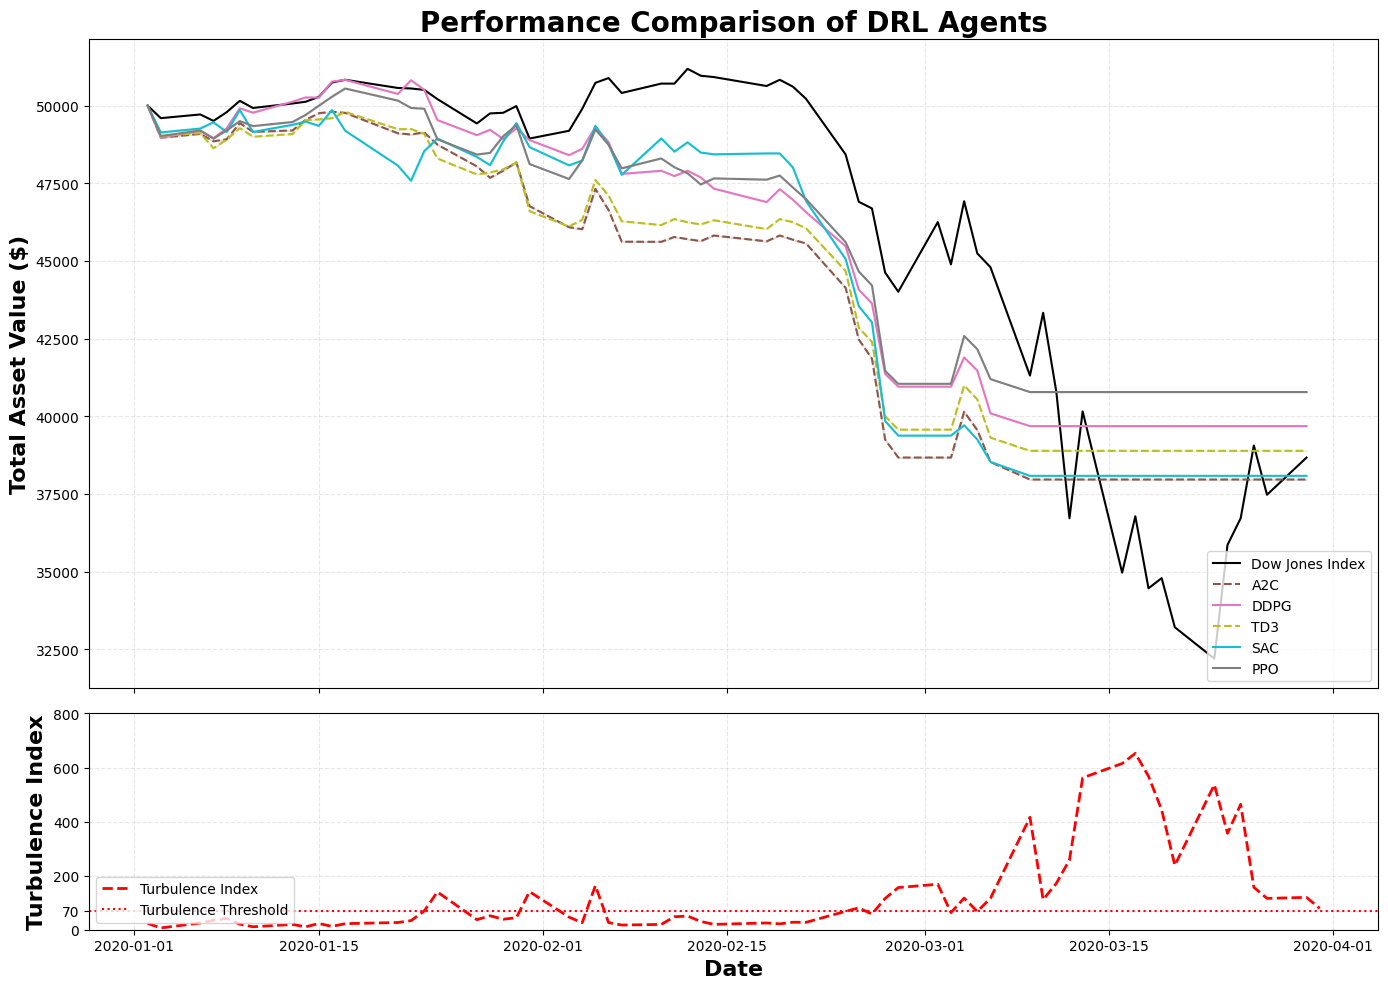

In [164]:
#@title plot_results (separate turbulence plot)

def plot_results(result, experiment_stats, turbulence_series=None, turbulence_threshold=70):
    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Main plot
    method_styles = {
        'A2C': {'color': '#8c564b', 'linestyle': '--'},
        'DDPG': {'color': '#e377c2', 'linestyle': '-'},
        'PPO': {'color': '#7f7f7f', 'linestyle': '-'},
        'TD3': {'color': '#bcbd22', 'linestyle': '--'},
        'SAC': {'color': '#17becf', 'linestyle': '-'},
        'DJIA': {'color': '#000000', 'linestyle': '-'},
    }

    ax1.plot(result.index, result['DJIA'], label="Dow Jones Index",
             linestyle=method_styles['DJIA']['linestyle'], color=method_styles['DJIA']['color'])

    for exp_name, stats in experiment_stats.items():
        mean = stats['mean'].reindex(result.index).fillna(method='ffill')
        std = stats['std'].reindex(result.index).fillna(0)

        style = method_styles[exp_name]
        ax1.plot(result.index, mean, label=exp_name, **style)
        ax1.fill_between(result.index, mean - std, mean + std, color=style['color'], alpha=0.2)

    # Customize main plot
    ax1.set_title("Performance Comparison of DRL Agents", fontsize=20, fontweight='bold')
    ax1.set_ylabel("Total Asset Value ($)", fontsize=16, fontweight='bold')
    ax1.legend(loc='lower right')
    ax1.grid(True, linestyle='--', alpha=0.3)

    # Turbulence plot
    if turbulence_series is not None:
        ax2.plot(turbulence_series.index, turbulence_series, label="Turbulence Index", color='red', linestyle='--', linewidth=2)
        ax2.axhline(y=turbulence_threshold, color='red', linestyle=':', label='Turbulence Threshold')
        ax2.set_ylabel("Turbulence Index", fontsize=16, fontweight='bold')
        ax2.legend(loc='lower left')
        ax2.grid(True, linestyle='--', alpha=0.3)
        max_turbulence = max(turbulence_series.max(), turbulence_threshold)
        ax2.set_ylim(0, max_turbulence + 10)
        ax2.set_yticks(list(ax2.get_yticks()) + [turbulence_threshold])

    # Shared x-axis label
    ax2.set_xlabel("Date", fontsize=16, fontweight='bold')

    # Tight layout
    plt.tight_layout()
    return fig

# Example usage:
fig = plot_results(result, experiment_stats, turbulence_series)
plt.show()

In [30]:
#@title log_plot_as_artifact

import os
import matplotlib.pyplot as plt
import wandb

def log_plot_as_artifact(fig, artifact_name_prefix, artifact_type="plot"):
    print('log_plot_as_artifact')
    """
    Save a Matplotlib figure without clipping and log it as a W&B artifact.

    Parameters:
        fig (matplotlib.figure.Figure): The Matplotlib figure to save and log.
        artifact_name (str): The name of the W&B artifact.
        artifact_type (str): The type of the artifact (default is "plot").
        filename (str): The filename to save the plot as (default is "plot.png").
    """
    try:
        # Get full artifact name
        artifact_name = f'{artifact_name_prefix}-{wandb.run.id}'
        filename = artifact_name + '.png'

        # Save the figure with tight layout and proper padding
        fig.savefig(filename, bbox_inches='tight', pad_inches=0.1, dpi=300)
        plt.close(fig)  # Close the figure to free up memory

        # Create and log the W&B artifact
        artifact = wandb.Artifact(artifact_name, type=artifact_type)
        artifact.add_file(filename, skip_cache=True, overwrite=True)
        wandb.log_artifact(artifact)
    finally:
        # Ensure the file is deleted after use
        if os.path.exists(filename):
            os.remove(filename)

log_plot_as_artifact(fig, "performance_comparison_DRL_agents", artifact_type="plot")

log_plot_as_artifact


# Run metrics logging

In [31]:
#@title run_prediction_and_log_metrics

def _run_prediction_and_log_metrics(df, split_label, turbulence_threshold=None):
    assert split_label in ['train', 'val', 'test']

    df = fix_daily_index(df)

    e_gym = init_env(df, config, turbulence_threshold=turbulence_threshold)
    result, turbulence_series = get_predictions(e_gym, config, return_turbulence=True)
    result = add_djia_test(df, result, config)

    metrics_df, metrics_summary_df, experiment_stats = calculate_metrics(result)
    log_test_metrics(metrics_summary_df)
    metrics_all = result_df_to_metrics_dict(metrics_summary_df)

    if turbulence_threshold is None:
        turbulence_threshold = e_gym.turbulence_threshold

    log_nested_metrics(split_label, {'turb_th': turbulence_threshold})

    for model_name, metrics in metrics_all.items():
        log_metrics(metrics, model_name, split_label)
        update_best_model_metrics(metrics, model_name, split_label)

    if split_label == 'test':
        update_chosen_model_metrics()


        fig = plot_results(
            result, experiment_stats,
            turbulence_series,
            turbulence_threshold = turbulence_threshold
        )

        log_plot_as_artifact(fig, artifact_name_prefix="performance_comparison_DRL_agents", artifact_type="plot")

def run_prediction_and_log_metrics(run_id, turbulence_threshold=None):
    with wandb.init(project=PROJECT, entity=ENTITY, id=run_id, resume='must'):
        config = wandb.run.config

        download_artifacts(run_id)
        train, val, trade = load_data(config)

        _run_prediction_and_log_metrics(val, split_label='val')
        _run_prediction_and_log_metrics(trade, split_label='test', turbulence_threshold=turbulence_threshold)

In [ ]:
#@title Log metrics for a RUN

run_prediction_and_log_metrics(
    run_id = 'lihccc7l',
    turbulence_threshold = 20
)

True


wandb:   3 of 3 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Stock Dimension: 29, State Space: 291
hit end!
hit end!
hit end!
hit end!


[*********************100%***********************]  1 of 1 completed

hit end!

2019-10-01 00:00:00
2019-12-31 00:00:00
Shape of DataFrame:  (63, 8)
{'dataset_name': 'DOW-30 | 2009-01 | 2019 Q4 | 2020 Q1', 'if_using_ddpg': True, 'finetune': True, 'max_test_end_date': '2020-08-05', 'REFERENCE_PRICE_END_DATE': '2024-12-21', 'cost_abs': 2.5, 'dataset_type': 'quarterly_train_val_test', 'cost_pct': [0.010314179718673032, 0.009076606561755468, 0.008307067100246136, 0.015516293581809112, 0.006395481989312903, 0.0072110283262062785, 0.04249566955190291, 0.015979716445954528, 0.021738725278835313, 0.004222453318177087, 0.005968143721526647, 0.010896151366589463, 0.01093735188446354, 0.11420864277075855, 0.01665255165637118, 0.010252194206940846, 0.03947813656400475, 0.008462643895002689, 0.01919729692524921, 0.024719550845968045, 0.005734449144229167, 0.03210832438433615, 0.014379031318205482, 0.00982580254909786, 0.0044498520553265045, 0.007984135151425499, 0.05881990501271046, 0.270946766931955, 0.026832260273111815], 'train_start_date': '2009-01-01', 'if_using

True
log_metrics for a2c
True
DEBUG (val): run.id = lihccc7l
DEBUG (val): sharpe_ratios = {}
DEBUG (val): updating best model based on sharpe_ratios: {}
DEBUG (val): no models logged yet, new best model is current one: a2c
DEBUG (val): wandb.run.config['sharpe_ratios'] = {'val': {}}
log_metrics for best_model
True
log_metrics for ddpg
True
DEBUG (val): run.id = lihccc7l
DEBUG (val): sharpe_ratios = {'a2c': 1.77}
DEBUG (val): updating best model based on sharpe_ratios: {'a2c': 1.77}
DEBUG (val): 2.64 (ddpg) > 1.77 (a2c). New best model: ddpg.
log_metrics for best_model
True
True
log_metrics for td3
True
DEBUG (val): run.id = lihccc7l
DEBUG (val): sharpe_ratios = {'a2c': 1.77, 'ddpg': 2.64}
DEBUG (val): updating best model based on sharpe_ratios: {'a2c': 1.77, 'ddpg': 2.64}
DEBUG (val): 3.59 (td3) > 2.64 (ddpg). New best model: td3.
log_metrics for best_model
True
True
log_metrics for sac
True
DEBUG (val): run.id = lihccc7l
DEBUG (val): sharpe_ratios = {'a2c': 1.77, 'ddpg': 2.64, 'td3': 

[*********************100%***********************]  1 of 1 completed

hit end!

2020-01-02 00:00:00
2020-03-31 00:00:00
Shape of DataFrame:  (61, 8)
{'dataset_name': 'DOW-30 | 2009-01 | 2019 Q4 | 2020 Q1', 'if_using_ddpg': True, 'finetune': True, 'max_test_end_date': '2020-08-05', 'REFERENCE_PRICE_END_DATE': '2024-12-21', 'cost_abs': 2.5, 'dataset_type': 'quarterly_train_val_test', 'cost_pct': [0.010314179718673032, 0.009076606561755468, 0.008307067100246136, 0.015516293581809112, 0.006395481989312903, 0.0072110283262062785, 0.04249566955190291, 0.015979716445954528, 0.021738725278835313, 0.004222453318177087, 0.005968143721526647, 0.010896151366589463, 0.01093735188446354, 0.11420864277075855, 0.01665255165637118, 0.010252194206940846, 0.03947813656400475, 0.008462643895002689, 0.01919729692524921, 0.024719550845968045, 0.005734449144229167, 0.03210832438433615, 0.014379031318205482, 0.00982580254909786, 0.0044498520553265045, 0.007984135151425499, 0.05881990501271046, 0.270946766931955, 0.026832260273111815], 'train_start_date': '2009-01-01', 'if_using

True
log_metrics for a2c
True
DEBUG (test): run.id = lihccc7l
DEBUG (test): sharpe_ratios = {}
DEBUG (test): updating best model based on sharpe_ratios: {}
DEBUG (test): no models logged yet, new best model is current one: a2c
DEBUG (test): wandb.run.config['sharpe_ratios'] = {'val': {'a2c': 1.77, 'ddpg': 2.64, 'td3': 3.59, 'sac': -1.11, 'ppo': 5.11}, 'test': {}}
log_metrics for best_model
True
log_metrics for ddpg
True
DEBUG (test): run.id = lihccc7l
DEBUG (test): sharpe_ratios = {'a2c': -1.86}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': -1.86}
DEBUG (test): -1.6 (ddpg) > -1.86 (a2c). New best model: ddpg.
log_metrics for best_model
True
True
log_metrics for td3
True
DEBUG (test): run.id = lihccc7l
DEBUG (test): sharpe_ratios = {'a2c': -1.86, 'ddpg': -1.6}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': -1.86, 'ddpg': -1.6}
DEBUG (test): -2.02 (td3) <= -1.6 (ddpg). Not updating best model.
log_metrics for sac
True
DEBUG (test): run.id = lihccc7l

best_model_name,a2c
test/ann_return/a2c,-23.12
test/ann_return/best_model,-25.49
test/ann_return/ddpg,-18.3
test/ann_return/ppo,-13.02
test/ann_return/sac,-11.71
test/ann_return/td3,-25.49
test/best_model_name,td3
test/cum_return/a2c,-6.14
test/cum_return/best_model,-6.85
test/cum_return/ddpg,-4.76


In [ ]:
#@title Log metrics for a SWEEP
from tqdm.notebook import tqdm

# SWEEP_ID = 'k43io2uh'
# SWEEP_ID = 'ebyzng3y'
SWEEP_ID = 'k43io2uh'
TURBULENCE_TH = 30

##################

api = wandb.Api()
sweep = api.sweep(f'{ENTITY}/{PROJECT}/{SWEEP_ID}')

wandb.finish()
for run in tqdm(sweep.runs):
    # print(f"\nRun: {run.id}")
    run_prediction_and_log_metrics(run.id, turbulence_threshold=TURBULENCE_TH)
    # pass

best_model_name,a2c
test/ann_return/a2c,-68.06
test/ann_return/best_model,-68.06
test/ann_return/ddpg,-62.82
test/ann_return/ppo,-30.44
test/ann_return/sac,-75.24
test/ann_return/td3,-61.1
test/best_model_name,a2c
test/cum_return/a2c,-24.05
test/cum_return/best_model,-24.05
test/cum_return/ddpg,-21.22


True
True
True
True
True
True
True
True
True
True


  0%|          | 0/17 [00:00<?, ?it/s]

True


wandb:   3 of 3 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Stock Dimension: 29, State Space: 291
hit end!
hit end!
hit end!
hit end!


[*********************100%***********************]  1 of 1 completed

hit end!

2020-01-02 00:00:00
2020-03-31 00:00:00
Shape of DataFrame:  (61, 8)
{'cost_abs': 2.5, 'if_using_a2c': True, 'initial_amount': 50000, 'if_using_ddpg': True, 'stock_index_name': 'DOW-30', 'dataset_name': 'DOW-30 | 2009-01 | 2019 Q4 | 2020 Q1', 'REFERNCE_PRICE_WINDOW_DAYS': 30, 'dataset_type': 'quarterly_train_val_test', 'date_range': {'test_end_date': '2020-04-01 00:00:00', 'val_start_date': '2019-10-01 00:00:00', 'test_start_date': '2020-01-01 00:00:00', 'train_start_date': '2009-01-01 00:00:00'}, 'finetune': True, 'if_using_sac': True, 'min_test_start_date': '2016-01-01', 'if_using_td3': True, 'train_params': {'a2c': {'steps': 50000}, 'ppo': {'steps': 200000}, 'sac': {'steps': 70000}, 'td3': {'steps': 50000}, 'ddpg': {'steps': 50000}}, 'train_start_date': '2009-01-01', 'max_test_end_date': '2020-08-05', 'cost_pct': [0.010314179718673032, 0.009076606561755468, 0.008307067100246136, 0.015516293581809112, 0.006395481989312903, 0.0072110283262062785, 0.04249566955190291, 0.01597

True
log_metrics for a2c
True
DEBUG (test): run.id = lihccc7l
DEBUG (test): sharpe_ratios = {}
DEBUG (test): updating best model based on sharpe_ratios: {}
DEBUG (test): no models logged yet, new best model is current one: a2c
DEBUG (test): wandb.run.config['sharpe_ratios'] = {'test': {}}
log_metrics for best_model
True
log_metrics for ddpg
True
DEBUG (test): run.id = lihccc7l
DEBUG (test): sharpe_ratios = {'a2c': -3.3}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': -3.3}
DEBUG (test): -3.31 (ddpg) <= -3.3 (a2c). Not updating best model.
log_metrics for td3
True
DEBUG (test): run.id = lihccc7l
DEBUG (test): sharpe_ratios = {'a2c': -3.3, 'ddpg': -3.31}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': -3.3, 'ddpg': -3.31}
DEBUG (test): -3.41 (td3) <= -3.3 (a2c). Not updating best model.
log_metrics for sac
True
DEBUG (test): run.id = lihccc7l
DEBUG (test): sharpe_ratios = {'a2c': -3.3, 'ddpg': -3.31, 'td3': -3.41}
DEBUG (test): updating best model base

best_model_name,a2c
test/ann_return/a2c,-46.35
test/ann_return/best_model,-48.0
test/ann_return/ddpg,-41.94
test/ann_return/ppo,-33.95
test/ann_return/sac,-40.0
test/ann_return/td3,-48.0
test/best_model_name,td3
test/cum_return/a2c,-13.94
test/cum_return/best_model,-14.59
test/cum_return/ddpg,-12.28


True


wandb:   3 of 3 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Stock Dimension: 29, State Space: 291
hit end!
hit end!
hit end!
hit end!


[*********************100%***********************]  1 of 1 completed

hit end!

2019-10-01 00:00:00
2019-12-31 00:00:00
Shape of DataFrame:  (63, 8)
{'if_using_td3': True, 'train_start_date': '2009-01-01', 'cost_abs': 2.5, 'REFERENCE_PRICE_END_DATE': '2024-12-21', 'if_using_ppo': True, 'if_using_ddpg': True, 'min_test_start_date': '2016-01-01', 'initial_amount': 50000, 'stock_index_name': 'DOW-30', 'if_using_a2c': True, 'REFERNCE_PRICE_WINDOW_DAYS': 30, 'finetune': True, 'max_test_end_date': '2020-08-05', 'dataset_name': 'DOW-30 | 2009-01 | 2019 Q3 | 2019 Q4', 'train_params': {'a2c': {'steps': 50000}, 'ppo': {'steps': 200000}, 'sac': {'steps': 70000}, 'td3': {'steps': 50000}, 'ddpg': {'steps': 50000}}, 'if_using_sac': True, 'cost_pct': [0.010314179718673032, 0.009076606561755468, 0.008307067100246136, 0.015516293581809112, 0.006395481989312903, 0.0072110283262062785, 0.04249566955190291, 0.015979716445954528, 0.021738725278835313, 0.004222453318177087, 0.005968143721526647, 0.010896151366589463, 0.01093735188446354, 0.11420864277075855, 0.016652551656371

True
log_metrics for a2c
True
DEBUG (test): run.id = 29wfsdq0
DEBUG (test): sharpe_ratios = {}
DEBUG (test): updating best model based on sharpe_ratios: {}
DEBUG (test): no models logged yet, new best model is current one: a2c
DEBUG (test): wandb.run.config['sharpe_ratios'] = {'test': {}}
log_metrics for best_model
True
log_metrics for ddpg
True
DEBUG (test): run.id = 29wfsdq0
DEBUG (test): sharpe_ratios = {'a2c': 1.77}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': 1.77}
DEBUG (test): 2.64 (ddpg) > 1.77 (a2c). New best model: ddpg.
log_metrics for best_model
True
True
log_metrics for td3
True
DEBUG (test): run.id = 29wfsdq0
DEBUG (test): sharpe_ratios = {'a2c': 1.77, 'ddpg': 2.64}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': 1.77, 'ddpg': 2.64}
DEBUG (test): 3.59 (td3) > 2.64 (ddpg). New best model: td3.
log_metrics for best_model
True
True
log_metrics for sac
True
DEBUG (test): run.id = 29wfsdq0
DEBUG (test): sharpe_ratios = {'a2c': 1.77, 'ddpg

best_model_name,a2c
test/ann_return/a2c,23.69
test/ann_return/best_model,60.99
test/ann_return/ddpg,41.26
test/ann_return/ppo,60.99
test/ann_return/sac,-23.35
test/ann_return/td3,53.12
test/best_model_name,ppo
test/cum_return/a2c,5.38
test/cum_return/best_model,12.46
test/cum_return/ddpg,8.89


True


wandb:   3 of 3 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Stock Dimension: 29, State Space: 291
hit end!
hit end!
hit end!
hit end!


[*********************100%***********************]  1 of 1 completed

hit end!

2019-07-01 00:00:00
2019-09-30 00:00:00
Shape of DataFrame:  (63, 8)
{'cost_pct': [0.010314179718673032, 0.009076606561755468, 0.008307067100246136, 0.015516293581809112, 0.006395481989312903, 0.0072110283262062785, 0.04249566955190291, 0.015979716445954528, 0.021738725278835313, 0.004222453318177087, 0.005968143721526647, 0.010896151366589463, 0.01093735188446354, 0.11420864277075855, 0.01665255165637118, 0.010252194206940846, 0.03947813656400475, 0.008462643895002689, 0.01919729692524921, 0.024719550845968045, 0.005734449144229167, 0.03210832438433615, 0.014379031318205482, 0.00982580254909786, 0.0044498520553265045, 0.007984135151425499, 0.05881990501271046, 0.270946766931955, 0.026832260273111815], 'max_test_end_date': '2020-08-05', 'if_using_ppo': True, 'if_using_td3': True, 'date_range': {'test_end_date': '2019-10-01 00:00:00', 'val_start_date': '2019-04-01 00:00:00', 'test_start_date': '2019-07-01 00:00:00', 'train_start_date': '2009-01-01 00:00:00'}, 'if_using_sac': T

True
log_metrics for a2c
True
DEBUG (test): run.id = 5kmr481u
DEBUG (test): sharpe_ratios = {}
DEBUG (test): updating best model based on sharpe_ratios: {}
DEBUG (test): no models logged yet, new best model is current one: a2c
DEBUG (test): wandb.run.config['sharpe_ratios'] = {'test': {}}
log_metrics for best_model
True
log_metrics for ddpg
True
DEBUG (test): run.id = 5kmr481u
DEBUG (test): sharpe_ratios = {'a2c': 0.7}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': 0.7}
DEBUG (test): 0.24 (ddpg) <= 0.7 (a2c). Not updating best model.
log_metrics for td3
True
DEBUG (test): run.id = 5kmr481u
DEBUG (test): sharpe_ratios = {'a2c': 0.7, 'ddpg': 0.24}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': 0.7, 'ddpg': 0.24}
DEBUG (test): 0.64 (td3) <= 0.7 (a2c). Not updating best model.
log_metrics for sac
True
DEBUG (test): run.id = 5kmr481u
DEBUG (test): sharpe_ratios = {'a2c': 0.7, 'ddpg': 0.24, 'td3': 0.64}
DEBUG (test): updating best model based on sharpe_r

best_model_name,a2c
test/ann_return/a2c,10.63
test/ann_return/best_model,22.49
test/ann_return/ddpg,2.79
test/ann_return/ppo,-5.3
test/ann_return/sac,22.49
test/ann_return/td3,9.49
test/best_model_name,sac
test/cum_return/a2c,2.46
test/cum_return/best_model,5.01
test/cum_return/ddpg,0.67


True


wandb:   3 of 3 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Stock Dimension: 29, State Space: 291
hit end!
hit end!
hit end!
hit end!


[*********************100%***********************]  1 of 1 completed

hit end!

2019-04-01 00:00:00
2019-06-28 00:00:00
Shape of DataFrame:  (62, 8)
{'if_using_ddpg': True, 'if_using_a2c': True, 'if_using_sac': True, 'initial_amount': 50000, 'max_test_end_date': '2020-08-05', 'REFERENCE_PRICE_END_DATE': '2024-12-21', 'REFERNCE_PRICE_WINDOW_DAYS': 30, 'finetune': True, 'dataset_type': 'quarterly_train_val_test', 'min_test_start_date': '2016-01-01', 'if_using_ppo': True, 'date_range': {'test_end_date': '2019-07-01 00:00:00', 'val_start_date': '2019-01-01 00:00:00', 'test_start_date': '2019-04-01 00:00:00', 'train_start_date': '2009-01-01 00:00:00'}, 'train_start_date': '2009-01-01', 'cost_pct': [0.010314179718673032, 0.009076606561755468, 0.008307067100246136, 0.015516293581809112, 0.006395481989312903, 0.0072110283262062785, 0.04249566955190291, 0.015979716445954528, 0.021738725278835313, 0.004222453318177087, 0.005968143721526647, 0.010896151366589463, 0.01093735188446354, 0.11420864277075855, 0.01665255165637118, 0.010252194206940846, 0.0394781365640047

True
log_metrics for a2c
True
DEBUG (test): run.id = 8zeoyh95
DEBUG (test): sharpe_ratios = {}
DEBUG (test): updating best model based on sharpe_ratios: {}
DEBUG (test): no models logged yet, new best model is current one: a2c
DEBUG (test): wandb.run.config['sharpe_ratios'] = {'test': {}}
log_metrics for best_model
True
log_metrics for ddpg
True
DEBUG (test): run.id = 8zeoyh95
DEBUG (test): sharpe_ratios = {'a2c': 0.84}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': 0.84}
DEBUG (test): 1.49 (ddpg) > 0.84 (a2c). New best model: ddpg.
log_metrics for best_model
True
True
log_metrics for td3
True
DEBUG (test): run.id = 8zeoyh95
DEBUG (test): sharpe_ratios = {'a2c': 0.84, 'ddpg': 1.49}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': 0.84, 'ddpg': 1.49}
DEBUG (test): 0.74 (td3) <= 1.49 (ddpg). Not updating best model.
log_metrics for sac
True
DEBUG (test): run.id = 8zeoyh95
DEBUG (test): sharpe_ratios = {'a2c': 0.84, 'ddpg': 1.49, 'td3': 0.74}
DEBUG (tes

best_model_name,a2c
test/ann_return/a2c,11.98
test/ann_return/best_model,17.96
test/ann_return/ddpg,17.96
test/ann_return/ppo,11.98
test/ann_return/sac,3.58
test/ann_return/td3,8.06
test/best_model_name,ddpg
test/cum_return/a2c,2.73
test/cum_return/best_model,4.01
test/cum_return/ddpg,4.01


True


wandb:   3 of 3 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Stock Dimension: 29, State Space: 291
hit end!
hit end!
hit end!
hit end!


[*********************100%***********************]  1 of 1 completed

hit end!

2019-01-02 00:00:00
2019-03-29 00:00:00
Shape of DataFrame:  (60, 8)
{'date_range': {'test_start_date': '2019-01-01 00:00:00', 'train_start_date': '2009-01-01 00:00:00', 'test_end_date': '2019-04-01 00:00:00', 'val_start_date': '2018-10-01 00:00:00'}, 'REFERNCE_PRICE_WINDOW_DAYS': 30, 'train_start_date': '2009-01-01', 'if_using_a2c': True, 'stock_index_name': 'DOW-30', 'if_using_ppo': True, 'initial_amount': 50000, 'cost_abs': 2.5, 'if_using_td3': True, 'if_using_ddpg': True, 'finetune': True, 'train_params': {'ppo': {'steps': 200000}, 'sac': {'steps': 70000}, 'td3': {'steps': 50000}, 'ddpg': {'steps': 50000}, 'a2c': {'steps': 50000}}, 'max_test_end_date': '2020-08-05', 'if_using_sac': True, 'dataset_type': 'quarterly_train_val_test', 'REFERENCE_PRICE_END_DATE': '2024-12-21', 'dataset_name': 'DOW-30 | 2009-01 | 2018 Q4 | 2019 Q1', 'cost_pct': [0.010314179718673032, 0.009076606561755468, 0.008307067100246136, 0.015516293581809112, 0.006395481989312903, 0.0072110283262062785, 0

True
log_metrics for a2c
True
DEBUG (test): run.id = tumg13f0
DEBUG (test): sharpe_ratios = {}
DEBUG (test): updating best model based on sharpe_ratios: {}
DEBUG (test): no models logged yet, new best model is current one: a2c
DEBUG (test): wandb.run.config['sharpe_ratios'] = {'test': {}}
log_metrics for best_model
True
log_metrics for ddpg
True
DEBUG (test): run.id = tumg13f0
DEBUG (test): sharpe_ratios = {'a2c': 1.85}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': 1.85}
DEBUG (test): 2.65 (ddpg) > 1.85 (a2c). New best model: ddpg.
log_metrics for best_model
True
True
log_metrics for td3
True
DEBUG (test): run.id = tumg13f0
DEBUG (test): sharpe_ratios = {'a2c': 1.85, 'ddpg': 2.65}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': 1.85, 'ddpg': 2.65}
DEBUG (test): 1.49 (td3) <= 2.65 (ddpg). Not updating best model.
log_metrics for sac
True
DEBUG (test): run.id = tumg13f0
DEBUG (test): sharpe_ratios = {'a2c': 1.85, 'ddpg': 2.65, 'td3': 1.49}
DEBUG (tes

best_model_name,a2c
test/ann_return/a2c,27.92
test/ann_return/best_model,58.62
test/ann_return/ddpg,58.62
test/ann_return/ppo,38.34
test/ann_return/sac,41.45
test/ann_return/td3,27.63
test/best_model_name,ddpg
test/cum_return/a2c,5.9
test/cum_return/best_model,11.34
test/cum_return/ddpg,11.34


True


wandb:   3 of 3 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Stock Dimension: 29, State Space: 291
hit end!
hit end!
hit end!
hit end!


[*********************100%***********************]  1 of 1 completed

hit end!

2018-10-01 00:00:00
2018-12-31 00:00:00
Shape of DataFrame:  (62, 8)
{'if_using_ppo': True, 'dataset_name': 'DOW-30 | 2009-01 | 2018 Q3 | 2018 Q4', 'cost_pct': [0.010314179718673032, 0.009076606561755468, 0.008307067100246136, 0.015516293581809112, 0.006395481989312903, 0.0072110283262062785, 0.04249566955190291, 0.015979716445954528, 0.021738725278835313, 0.004222453318177087, 0.005968143721526647, 0.010896151366589463, 0.01093735188446354, 0.11420864277075855, 0.01665255165637118, 0.010252194206940846, 0.03947813656400475, 0.008462643895002689, 0.01919729692524921, 0.024719550845968045, 0.005734449144229167, 0.03210832438433615, 0.014379031318205482, 0.00982580254909786, 0.0044498520553265045, 0.007984135151425499, 0.05881990501271046, 0.270946766931955, 0.026832260273111815], 'if_using_a2c': True, 'date_range': {'test_end_date': '2019-01-01 00:00:00', 'val_start_date': '2018-07-01 00:00:00', 'test_start_date': '2018-10-01 00:00:00', 'train_start_date': '2009-01-01 00:00:00

True
log_metrics for a2c
True
DEBUG (test): run.id = o2bz2ear
DEBUG (test): sharpe_ratios = {}
DEBUG (test): updating best model based on sharpe_ratios: {}
DEBUG (test): no models logged yet, new best model is current one: a2c
DEBUG (test): wandb.run.config['sharpe_ratios'] = {'test': {}}
log_metrics for best_model
True
log_metrics for ddpg
True
DEBUG (test): run.id = o2bz2ear
DEBUG (test): sharpe_ratios = {'a2c': -2.41}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': -2.41}
DEBUG (test): -2.84 (ddpg) <= -2.41 (a2c). Not updating best model.
log_metrics for td3
True
DEBUG (test): run.id = o2bz2ear
DEBUG (test): sharpe_ratios = {'a2c': -2.41, 'ddpg': -2.84}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': -2.41, 'ddpg': -2.84}
DEBUG (test): -2.17 (td3) > -2.41 (a2c). New best model: td3.
log_metrics for best_model
True
True
log_metrics for sac
True
DEBUG (test): run.id = o2bz2ear
DEBUG (test): sharpe_ratios = {'a2c': -2.41, 'ddpg': -2.84, 'td3': -2.17}

best_model_name,a2c
test/ann_return/a2c,-55.92
test/ann_return/best_model,-68.97
test/ann_return/ddpg,-47.33
test/ann_return/ppo,-39.3
test/ann_return/sac,-68.97
test/ann_return/td3,-43.09
test/best_model_name,sac
test/cum_return/a2c,-17.92
test/cum_return/best_model,-24.58
test/cum_return/ddpg,-14.32


True


wandb:   3 of 3 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Stock Dimension: 29, State Space: 291
hit end!
hit end!
hit end!
hit end!


[*********************100%***********************]  1 of 1 completed

hit end!

2018-07-02 00:00:00
2018-09-28 00:00:00
Shape of DataFrame:  (62, 8)
{'dataset_name': 'DOW-30 | 2009-01 | 2018 Q2 | 2018 Q3', 'min_test_start_date': '2016-01-01', 'train_params': {'a2c': {'steps': 50000}, 'ppo': {'steps': 200000}, 'sac': {'steps': 70000}, 'td3': {'steps': 50000}, 'ddpg': {'steps': 50000}}, 'finetune': True, 'if_using_ddpg': True, 'if_using_td3': True, 'REFERENCE_PRICE_END_DATE': '2024-12-21', 'initial_amount': 50000, 'if_using_sac': True, 'date_range': {'test_end_date': '2018-10-01 00:00:00', 'val_start_date': '2018-04-01 00:00:00', 'test_start_date': '2018-07-01 00:00:00', 'train_start_date': '2009-01-01 00:00:00'}, 'cost_pct': [0.010314179718673032, 0.009076606561755468, 0.008307067100246136, 0.015516293581809112, 0.006395481989312903, 0.0072110283262062785, 0.04249566955190291, 0.015979716445954528, 0.021738725278835313, 0.004222453318177087, 0.005968143721526647, 0.010896151366589463, 0.01093735188446354, 0.11420864277075855, 0.01665255165637118, 0.010252

True
log_metrics for a2c
True
DEBUG (test): run.id = h1ia8if0
DEBUG (test): sharpe_ratios = {}
DEBUG (test): updating best model based on sharpe_ratios: {}
DEBUG (test): no models logged yet, new best model is current one: a2c
DEBUG (test): wandb.run.config['sharpe_ratios'] = {'test': {}}
log_metrics for best_model
True
log_metrics for ddpg
True
DEBUG (test): run.id = h1ia8if0
DEBUG (test): sharpe_ratios = {'a2c': 3.6}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': 3.6}
DEBUG (test): 2.7 (ddpg) <= 3.6 (a2c). Not updating best model.
log_metrics for td3
True
DEBUG (test): run.id = h1ia8if0
DEBUG (test): sharpe_ratios = {'a2c': 3.6, 'ddpg': 2.7}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': 3.6, 'ddpg': 2.7}
DEBUG (test): 3.33 (td3) <= 3.6 (a2c). Not updating best model.
log_metrics for sac
True
DEBUG (test): run.id = h1ia8if0
DEBUG (test): sharpe_ratios = {'a2c': 3.6, 'ddpg': 2.7, 'td3': 3.33}
DEBUG (test): updating best model based on sharpe_ratio

best_model_name,a2c
test/ann_return/a2c,43.77
test/ann_return/best_model,55.87
test/ann_return/ddpg,33.81
test/ann_return/ppo,55.87
test/ann_return/sac,36.07
test/ann_return/td3,47.46
test/best_model_name,ppo
test/cum_return/a2c,9.04
test/cum_return/best_model,11.16
test/cum_return/ddpg,7.19


True


wandb:   3 of 3 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Stock Dimension: 29, State Space: 291
hit end!
hit end!
hit end!
hit end!


[*********************100%***********************]  1 of 1 completed

hit end!

2018-04-02 00:00:00
2018-06-29 00:00:00
Shape of DataFrame:  (63, 8)
{'train_start_date': '2009-01-01', 'cost_abs': 2.5, 'finetune': True, 'min_test_start_date': '2016-01-01', 'REFERNCE_PRICE_WINDOW_DAYS': 30, 'date_range': {'test_end_date': '2018-07-01 00:00:00', 'val_start_date': '2018-01-01 00:00:00', 'test_start_date': '2018-04-01 00:00:00', 'train_start_date': '2009-01-01 00:00:00'}, 'REFERENCE_PRICE_END_DATE': '2024-12-21', 'stock_index_name': 'DOW-30', 'if_using_td3': True, 'if_using_ddpg': True, 'if_using_a2c': True, 'initial_amount': 50000, 'cost_pct': [0.010314179718673032, 0.009076606561755468, 0.008307067100246136, 0.015516293581809112, 0.006395481989312903, 0.0072110283262062785, 0.04249566955190291, 0.015979716445954528, 0.021738725278835313, 0.004222453318177087, 0.005968143721526647, 0.010896151366589463, 0.01093735188446354, 0.11420864277075855, 0.01665255165637118, 0.010252194206940846, 0.03947813656400475, 0.008462643895002689, 0.01919729692524921, 0.024719

True
log_metrics for a2c
True
DEBUG (test): run.id = zvkqngwt
DEBUG (test): sharpe_ratios = {}
DEBUG (test): updating best model based on sharpe_ratios: {}
DEBUG (test): no models logged yet, new best model is current one: a2c
DEBUG (test): wandb.run.config['sharpe_ratios'] = {'test': {}}
log_metrics for best_model
True
log_metrics for ddpg
True
DEBUG (test): run.id = zvkqngwt
DEBUG (test): sharpe_ratios = {'a2c': 0.51}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': 0.51}
DEBUG (test): -1.11 (ddpg) <= 0.51 (a2c). Not updating best model.
log_metrics for td3
True
DEBUG (test): run.id = zvkqngwt
DEBUG (test): sharpe_ratios = {'a2c': 0.51, 'ddpg': -1.11}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': 0.51, 'ddpg': -1.11}
DEBUG (test): 0.95 (td3) > 0.51 (a2c). New best model: td3.
log_metrics for best_model
True
True
log_metrics for sac
True
DEBUG (test): run.id = zvkqngwt
DEBUG (test): sharpe_ratios = {'a2c': 0.51, 'ddpg': -1.11, 'td3': 0.95}
DEBUG (t

best_model_name,a2c
test/ann_return/a2c,8.97
test/ann_return/best_model,13.71
test/ann_return/ddpg,-15.69
test/ann_return/ppo,13.71
test/ann_return/sac,-25.97
test/ann_return/td3,12.51
test/best_model_name,ppo
test/cum_return/a2c,2.07
test/cum_return/best_model,3.11
test/cum_return/ddpg,-3.99


True


wandb:   3 of 3 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   4 of 4 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Stock Dimension: 29, State Space: 291
hit end!
hit end!
hit end!
hit end!


[*********************100%***********************]  1 of 1 completed

hit end!

2018-01-02 00:00:00
2018-03-29 00:00:00
Shape of DataFrame:  (60, 8)
{'dataset_name': 'DOW-30 | 2009-01 | 2017 Q4 | 2018 Q1', 'if_using_ppo': True, 'if_using_a2c': True, 'if_using_td3': True, 'min_test_start_date': '2016-01-01', 'train_start_date': '2009-01-01', 'REFERENCE_PRICE_END_DATE': '2024-12-21', 'initial_amount': 50000, 'dataset_type': 'quarterly_train_val_test', 'cost_pct': [0.010314179718673032, 0.009076606561755468, 0.008307067100246136, 0.015516293581809112, 0.006395481989312903, 0.0072110283262062785, 0.04249566955190291, 0.015979716445954528, 0.021738725278835313, 0.004222453318177087, 0.005968143721526647, 0.010896151366589463, 0.01093735188446354, 0.11420864277075855, 0.01665255165637118, 0.010252194206940846, 0.03947813656400475, 0.008462643895002689, 0.01919729692524921, 0.024719550845968045, 0.005734449144229167, 0.03210832438433615, 0.014379031318205482, 0.00982580254909786, 0.0044498520553265045, 0.007984135151425499, 0.05881990501271046, 0.27094676693195

True
log_metrics for a2c
True
DEBUG (test): run.id = n8squ0fj
DEBUG (test): sharpe_ratios = {}
DEBUG (test): updating best model based on sharpe_ratios: {}
DEBUG (test): no models logged yet, new best model is current one: a2c
DEBUG (test): wandb.run.config['sharpe_ratios'] = {'test': {}}
log_metrics for best_model
True
log_metrics for ddpg
True
DEBUG (test): run.id = n8squ0fj
DEBUG (test): sharpe_ratios = {'a2c': -1.9}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': -1.9}
DEBUG (test): -1.24 (ddpg) > -1.9 (a2c). New best model: ddpg.
log_metrics for best_model
True
True
log_metrics for td3
True
DEBUG (test): run.id = n8squ0fj
DEBUG (test): sharpe_ratios = {'a2c': -1.9, 'ddpg': -1.24}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': -1.9, 'ddpg': -1.24}
DEBUG (test): -0.63 (td3) > -1.24 (ddpg). New best model: td3.
log_metrics for best_model
True
True
log_metrics for sac
True
DEBUG (test): run.id = n8squ0fj
DEBUG (test): sharpe_ratios = {'a2c': -1.9, 

best_model_name,a2c
test/ann_return/a2c,-45.68
test/ann_return/best_model,-45.68
test/ann_return/ddpg,-24.74
test/ann_return/ppo,-23.29
test/ann_return/sac,-17.35
test/ann_return/td3,-14.25
test/best_model_name,a2c
test/cum_return/a2c,-13.25
test/cum_return/best_model,-13.25
test/cum_return/ddpg,-6.41


True


wandb:   3 of 3 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   4 of 4 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Stock Dimension: 29, State Space: 291
hit end!
hit end!
hit end!
hit end!


[*********************100%***********************]  1 of 1 completed

hit end!

2017-10-02 00:00:00
2017-12-29 00:00:00
Shape of DataFrame:  (62, 8)
{'initial_amount': 50000, 'if_using_ddpg': True, 'if_using_td3': True, 'dataset_name': 'DOW-30 | 2009-01 | 2017 Q3 | 2017 Q4', 'REFERENCE_PRICE_END_DATE': '2024-12-21', 'if_using_ppo': True, 'train_params': {'ddpg': {'steps': 50000}, 'a2c': {'steps': 50000}, 'ppo': {'steps': 200000}, 'sac': {'steps': 70000}, 'td3': {'steps': 50000}}, 'train_start_date': '2009-01-01', 'finetune': False, 'if_using_sac': True, 'if_using_a2c': True, 'cost_abs': 2.5, 'dataset_type': 'quarterly_train_val_test', 'cost_pct': [0.010314179718673032, 0.009076606561755468, 0.008307067100246136, 0.015516293581809112, 0.006395481989312903, 0.0072110283262062785, 0.04249566955190291, 0.015979716445954528, 0.021738725278835313, 0.004222453318177087, 0.005968143721526647, 0.010896151366589463, 0.01093735188446354, 0.11420864277075855, 0.01665255165637118, 0.010252194206940846, 0.03947813656400475, 0.008462643895002689, 0.01919729692524921, 0

True
log_metrics for a2c
True
DEBUG (test): run.id = 5wfrad9m
DEBUG (test): sharpe_ratios = {}
DEBUG (test): updating best model based on sharpe_ratios: {}
DEBUG (test): no models logged yet, new best model is current one: a2c
DEBUG (test): wandb.run.config['sharpe_ratios'] = {'test': {}}
log_metrics for best_model
True
log_metrics for ddpg
True
DEBUG (test): run.id = 5wfrad9m
DEBUG (test): sharpe_ratios = {'a2c': 2.25}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': 2.25}
DEBUG (test): 1.76 (ddpg) <= 2.25 (a2c). Not updating best model.
log_metrics for td3
True
DEBUG (test): run.id = 5wfrad9m
DEBUG (test): sharpe_ratios = {'a2c': 2.25, 'ddpg': 1.76}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': 2.25, 'ddpg': 1.76}
DEBUG (test): 3.11 (td3) > 2.25 (a2c). New best model: td3.
log_metrics for best_model
True
True
log_metrics for sac
True
DEBUG (test): run.id = 5wfrad9m
DEBUG (test): sharpe_ratios = {'a2c': 2.25, 'ddpg': 1.76, 'td3': 3.11}
DEBUG (test)

best_model_name,a2c
test/ann_return/a2c,27.08
test/ann_return/best_model,39.31
test/ann_return/ddpg,23.05
test/ann_return/ppo,14.03
test/ann_return/sac,39.31
test/ann_return/td3,33.54
test/best_model_name,sac
test/cum_return/a2c,5.88
test/cum_return/best_model,8.22
test/cum_return/ddpg,5.07


True
True
True
True
True
True
True


True


wandb:   3 of 3 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Stock Dimension: 29, State Space: 291
hit end!
hit end!
hit end!
hit end!


[*********************100%***********************]  1 of 1 completed

hit end!

2017-07-03 00:00:00
2017-09-29 00:00:00
Shape of DataFrame:  (62, 8)
{'if_using_td3': True, 'dataset_type': 'quarterly_train_val_test', 'REFERNCE_PRICE_WINDOW_DAYS': 30, 'train_params': {'a2c': {'steps': 50000}, 'ppo': {'steps': 200000}, 'sac': {'steps': 70000}, 'td3': {'steps': 50000}, 'ddpg': {'steps': 50000}}, 'finetune': True, 'if_using_a2c': True, 'cost_abs': 2.5, 'if_using_sac': True, 'train_start_date': '2009-01-01', 'if_using_ppo': True, 'stock_index_name': 'DOW-30', 'if_using_ddpg': True, 'initial_amount': 50000, 'max_test_end_date': '2020-08-05', 'cost_pct': [0.010314179718673032, 0.009076606561755468, 0.008307067100246136, 0.015516293581809112, 0.006395481989312903, 0.0072110283262062785, 0.04249566955190291, 0.015979716445954528, 0.021738725278835313, 0.004222453318177087, 0.005968143721526647, 0.010896151366589463, 0.01093735188446354, 0.11420864277075855, 0.01665255165637118, 0.010252194206940846, 0.03947813656400475, 0.008462643895002689, 0.01919729692524921, 0

True
log_metrics for a2c
True
DEBUG (test): run.id = 7kz7hrod
DEBUG (test): sharpe_ratios = {}
DEBUG (test): updating best model based on sharpe_ratios: {}
DEBUG (test): no models logged yet, new best model is current one: a2c
DEBUG (test): wandb.run.config['sharpe_ratios'] = {'test': {}}
log_metrics for best_model
True
log_metrics for ddpg
True
DEBUG (test): run.id = 7kz7hrod
DEBUG (test): sharpe_ratios = {'a2c': 1.51}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': 1.51}
DEBUG (test): 4.91 (ddpg) > 1.51 (a2c). New best model: ddpg.
log_metrics for best_model
True
True
log_metrics for td3
True
DEBUG (test): run.id = 7kz7hrod
DEBUG (test): sharpe_ratios = {'a2c': 1.51, 'ddpg': 4.91}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': 1.51, 'ddpg': 4.91}
DEBUG (test): -1.16 (td3) <= 4.91 (ddpg). Not updating best model.
log_metrics for sac
True
DEBUG (test): run.id = 7kz7hrod
DEBUG (test): sharpe_ratios = {'a2c': 1.51, 'ddpg': 4.91, 'td3': -1.16}
DEBUG (t

best_model_name,a2c
test/ann_return/a2c,15.42
test/ann_return/best_model,71.61
test/ann_return/ddpg,71.61
test/ann_return/ppo,16.7
test/ann_return/sac,12.02
test/ann_return/td3,-14.36
test/best_model_name,ddpg
test/cum_return/a2c,3.48
test/cum_return/best_model,13.74
test/cum_return/ddpg,13.74


True


wandb:   3 of 3 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Stock Dimension: 29, State Space: 291
hit end!
hit end!
hit end!
hit end!


[*********************100%***********************]  1 of 1 completed

hit end!

2017-04-03 00:00:00
2017-06-30 00:00:00
Shape of DataFrame:  (62, 8)
{'date_range': {'test_end_date': '2017-07-01 00:00:00', 'val_start_date': '2017-01-01 00:00:00', 'test_start_date': '2017-04-01 00:00:00', 'train_start_date': '2009-01-01 00:00:00'}, 'REFERNCE_PRICE_WINDOW_DAYS': 30, 'train_start_date': '2009-01-01', 'dataset_type': 'quarterly_train_val_test', 'REFERENCE_PRICE_END_DATE': '2024-12-21', 'if_using_ppo': True, 'finetune': True, 'if_using_td3': True, 'if_using_a2c': True, 'min_test_start_date': '2016-01-01', 'train_params': {'ppo': {'steps': 200000}, 'sac': {'steps': 70000}, 'td3': {'steps': 50000}, 'ddpg': {'steps': 50000}, 'a2c': {'steps': 50000}}, 'if_using_ddpg': True, 'cost_abs': 2.5, 'initial_amount': 50000, 'stock_index_name': 'DOW-30', 'if_using_sac': True, 'cost_pct': [0.010314179718673032, 0.009076606561755468, 0.008307067100246136, 0.015516293581809112, 0.006395481989312903, 0.0072110283262062785, 0.04249566955190291, 0.015979716445954528, 0.0217387252

True
log_metrics for a2c
True
DEBUG (test): run.id = 7ckhysh8
DEBUG (test): sharpe_ratios = {}
DEBUG (test): updating best model based on sharpe_ratios: {}
DEBUG (test): no models logged yet, new best model is current one: a2c
DEBUG (test): wandb.run.config['sharpe_ratios'] = {'test': {}}
log_metrics for best_model
True
log_metrics for ddpg
True
DEBUG (test): run.id = 7ckhysh8
DEBUG (test): sharpe_ratios = {'a2c': 2.97}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': 2.97}
DEBUG (test): 2.72 (ddpg) <= 2.97 (a2c). Not updating best model.
log_metrics for td3
True
DEBUG (test): run.id = 7ckhysh8
DEBUG (test): sharpe_ratios = {'a2c': 2.97, 'ddpg': 2.72}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': 2.97, 'ddpg': 2.72}
DEBUG (test): -3.06 (td3) <= 2.97 (a2c). Not updating best model.
log_metrics for sac
True
DEBUG (test): run.id = 7ckhysh8
DEBUG (test): sharpe_ratios = {'a2c': 2.97, 'ddpg': 2.72, 'td3': -3.06}
DEBUG (test): updating best model based on

best_model_name,a2c
test/ann_return/a2c,31.24
test/ann_return/best_model,36.91
test/ann_return/ddpg,25.86
test/ann_return/ppo,36.91
test/ann_return/sac,4.88
test/ann_return/td3,-30.21
test/best_model_name,ppo
test/cum_return/a2c,6.7
test/cum_return/best_model,7.78
test/cum_return/ddpg,5.63


True


wandb:   3 of 3 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Stock Dimension: 29, State Space: 291
hit end!
hit end!
hit end!
hit end!


[*********************100%***********************]  1 of 1 completed

hit end!

2017-01-03 00:00:00
2017-03-31 00:00:00
Shape of DataFrame:  (61, 8)
{'min_test_start_date': '2016-01-01', 'if_using_ppo': True, 'train_params': {'a2c': {'steps': 50000}, 'ppo': {'steps': 200000}, 'sac': {'steps': 70000}, 'td3': {'steps': 50000}, 'ddpg': {'steps': 50000}}, 'if_using_td3': True, 'max_test_end_date': '2020-08-05', 'if_using_sac': True, 'initial_amount': 50000, 'cost_pct': [0.010314179718673032, 0.009076606561755468, 0.008307067100246136, 0.015516293581809112, 0.006395481989312903, 0.0072110283262062785, 0.04249566955190291, 0.015979716445954528, 0.021738725278835313, 0.004222453318177087, 0.005968143721526647, 0.010896151366589463, 0.01093735188446354, 0.11420864277075855, 0.01665255165637118, 0.010252194206940846, 0.03947813656400475, 0.008462643895002689, 0.01919729692524921, 0.024719550845968045, 0.005734449144229167, 0.03210832438433615, 0.014379031318205482, 0.00982580254909786, 0.0044498520553265045, 0.007984135151425499, 0.05881990501271046, 0.2709467669

True
log_metrics for a2c
True
DEBUG (test): run.id = rizcli4c
DEBUG (test): sharpe_ratios = {}
DEBUG (test): updating best model based on sharpe_ratios: {}
DEBUG (test): no models logged yet, new best model is current one: a2c
DEBUG (test): wandb.run.config['sharpe_ratios'] = {'test': {}}
log_metrics for best_model
True
log_metrics for ddpg
True
DEBUG (test): run.id = rizcli4c
DEBUG (test): sharpe_ratios = {'a2c': 1.33}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': 1.33}
DEBUG (test): 2.69 (ddpg) > 1.33 (a2c). New best model: ddpg.
log_metrics for best_model
True
True
log_metrics for td3
True
DEBUG (test): run.id = rizcli4c
DEBUG (test): sharpe_ratios = {'a2c': 1.33, 'ddpg': 2.69}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': 1.33, 'ddpg': 2.69}
DEBUG (test): -0.16 (td3) <= 2.69 (ddpg). Not updating best model.
log_metrics for sac
True
DEBUG (test): run.id = rizcli4c
DEBUG (test): sharpe_ratios = {'a2c': 1.33, 'ddpg': 2.69, 'td3': -0.16}
DEBUG (t

best_model_name,a2c
test/ann_return/a2c,14.29
test/ann_return/best_model,38.41
test/ann_return/ddpg,30.33
test/ann_return/ppo,38.41
test/ann_return/sac,3.37
test/ann_return/td3,-2.16
test/best_model_name,ppo
test/cum_return/a2c,3.2
test/cum_return/best_model,7.96
test/cum_return/ddpg,6.44


True


wandb:   3 of 3 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Stock Dimension: 29, State Space: 291
hit end!
hit end!
hit end!
hit end!


[*********************100%***********************]  1 of 1 completed

hit end!

2016-10-03 00:00:00
2016-12-30 00:00:00
Shape of DataFrame:  (62, 8)
{'date_range': {'train_start_date': '2009-01-01 00:00:00', 'test_end_date': '2017-01-01 00:00:00', 'val_start_date': '2016-07-01 00:00:00', 'test_start_date': '2016-10-01 00:00:00'}, 'dataset_type': 'quarterly_train_val_test', 'if_using_td3': True, 'max_test_end_date': '2020-08-05', 'if_using_a2c': True, 'cost_pct': [0.010314179718673032, 0.009076606561755468, 0.008307067100246136, 0.015516293581809112, 0.006395481989312903, 0.0072110283262062785, 0.04249566955190291, 0.015979716445954528, 0.021738725278835313, 0.004222453318177087, 0.005968143721526647, 0.010896151366589463, 0.01093735188446354, 0.11420864277075855, 0.01665255165637118, 0.010252194206940846, 0.03947813656400475, 0.008462643895002689, 0.01919729692524921, 0.024719550845968045, 0.005734449144229167, 0.03210832438433615, 0.014379031318205482, 0.00982580254909786, 0.0044498520553265045, 0.007984135151425499, 0.05881990501271046, 0.2709467669319

True
log_metrics for a2c
True
DEBUG (test): run.id = g5hc85fb
DEBUG (test): sharpe_ratios = {}
DEBUG (test): updating best model based on sharpe_ratios: {}
DEBUG (test): no models logged yet, new best model is current one: a2c
DEBUG (test): wandb.run.config['sharpe_ratios'] = {'test': {}}
log_metrics for best_model
True
log_metrics for ddpg
True
DEBUG (test): run.id = g5hc85fb
DEBUG (test): sharpe_ratios = {'a2c': 0.5}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': 0.5}
DEBUG (test): 2.17 (ddpg) > 0.5 (a2c). New best model: ddpg.
log_metrics for best_model
True
True
log_metrics for td3
True
DEBUG (test): run.id = g5hc85fb
DEBUG (test): sharpe_ratios = {'a2c': 0.5, 'ddpg': 2.17}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': 0.5, 'ddpg': 2.17}
DEBUG (test): 1.72 (td3) <= 2.17 (ddpg). Not updating best model.
log_metrics for sac
True
DEBUG (test): run.id = g5hc85fb
DEBUG (test): sharpe_ratios = {'a2c': 0.5, 'ddpg': 2.17, 'td3': 1.72}
DEBUG (test): up

best_model_name,a2c
test/ann_return/a2c,5.86
test/ann_return/best_model,57.72
test/ann_return/ddpg,28.89
test/ann_return/ppo,31.57
test/ann_return/sac,57.72
test/ann_return/td3,24.12
test/best_model_name,sac
test/cum_return/a2c,1.37
test/cum_return/best_model,11.47
test/cum_return/ddpg,6.24


True


wandb:   3 of 3 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Stock Dimension: 29, State Space: 291
hit end!
hit end!
hit end!
hit end!


[*********************100%***********************]  1 of 1 completed

hit end!

2016-07-01 00:00:00
2016-09-30 00:00:00
Shape of DataFrame:  (63, 8)
{'REFERNCE_PRICE_WINDOW_DAYS': 30, 'min_test_start_date': '2016-01-01', 'date_range': {'test_end_date': '2016-10-01 00:00:00', 'val_start_date': '2016-04-01 00:00:00', 'test_start_date': '2016-07-01 00:00:00', 'train_start_date': '2009-01-01 00:00:00'}, 'if_using_ppo': True, 'dataset_type': 'quarterly_train_val_test', 'max_test_end_date': '2020-08-05', 'REFERENCE_PRICE_END_DATE': '2024-12-21', 'stock_index_name': 'DOW-30', 'cost_abs': 2.5, 'train_start_date': '2009-01-01', 'if_using_ddpg': True, 'train_params': {'a2c': {'steps': 50000}, 'ppo': {'steps': 200000}, 'sac': {'steps': 70000}, 'td3': {'steps': 50000}, 'ddpg': {'steps': 50000}}, 'if_using_a2c': True, 'if_using_sac': True, 'initial_amount': 50000, 'if_using_td3': True, 'finetune': True, 'dataset_name': 'DOW-30 | 2009-01 | 2016 Q2 | 2016 Q3', 'cost_pct': [0.010314179718673032, 0.009076606561755468, 0.008307067100246136, 0.015516293581809112, 0.0063954

True
log_metrics for a2c
True
DEBUG (test): run.id = ilv1yo6z
DEBUG (test): sharpe_ratios = {}
DEBUG (test): updating best model based on sharpe_ratios: {}
DEBUG (test): no models logged yet, new best model is current one: a2c
DEBUG (test): wandb.run.config['sharpe_ratios'] = {'test': {}}
log_metrics for best_model
True
log_metrics for ddpg
True
DEBUG (test): run.id = ilv1yo6z
DEBUG (test): sharpe_ratios = {'a2c': 0.41}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': 0.41}
DEBUG (test): -0.2 (ddpg) <= 0.41 (a2c). Not updating best model.
log_metrics for td3
True
DEBUG (test): run.id = ilv1yo6z
DEBUG (test): sharpe_ratios = {'a2c': 0.41, 'ddpg': -0.2}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': 0.41, 'ddpg': -0.2}
DEBUG (test): -1.78 (td3) <= 0.41 (a2c). Not updating best model.
log_metrics for sac
True
DEBUG (test): run.id = ilv1yo6z
DEBUG (test): sharpe_ratios = {'a2c': 0.41, 'ddpg': -0.2, 'td3': -1.78}
DEBUG (test): updating best model based on

best_model_name,a2c
test/ann_return/a2c,4.11
test/ann_return/best_model,4.84
test/ann_return/ddpg,-3.25
test/ann_return/ppo,-12.25
test/ann_return/sac,4.84
test/ann_return/td3,-23.11
test/best_model_name,sac
test/cum_return/a2c,1.0
test/cum_return/best_model,1.17
test/cum_return/ddpg,-0.81


True


wandb:   3 of 3 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Stock Dimension: 29, State Space: 291
hit end!
hit end!
hit end!
hit end!


[*********************100%***********************]  1 of 1 completed

hit end!

2016-04-01 00:00:00
2016-06-30 00:00:00
Shape of DataFrame:  (63, 8)
{'dataset_type': 'quarterly_train_val_test', 'if_using_ddpg': True, 'if_using_td3': True, 'finetune': True, 'min_test_start_date': '2016-01-01', 'dataset_name': 'DOW-30 | 2009-01 | 2016 Q1 | 2016 Q2', 'train_start_date': '2009-01-01', 'date_range': {'test_end_date': '2016-07-01 00:00:00', 'val_start_date': '2016-01-01 00:00:00', 'test_start_date': '2016-04-01 00:00:00', 'train_start_date': '2009-01-01 00:00:00'}, 'stock_index_name': 'DOW-30', 'if_using_a2c': True, 'initial_amount': 50000, 'REFERNCE_PRICE_WINDOW_DAYS': 30, 'train_params': {'ppo': {'steps': 200000}, 'sac': {'steps': 70000}, 'td3': {'steps': 50000}, 'ddpg': {'steps': 50000}, 'a2c': {'steps': 50000}}, 'if_using_ppo': True, 'REFERENCE_PRICE_END_DATE': '2024-12-21', 'cost_abs': 2.5, 'max_test_end_date': '2020-08-05', 'if_using_sac': True, 'cost_pct': [0.010314179718673032, 0.009076606561755468, 0.008307067100246136, 0.015516293581809112, 0.0063954

True
log_metrics for a2c
True
DEBUG (test): run.id = z64rbpbl
DEBUG (test): sharpe_ratios = {}
DEBUG (test): updating best model based on sharpe_ratios: {}
DEBUG (test): no models logged yet, new best model is current one: a2c
DEBUG (test): wandb.run.config['sharpe_ratios'] = {'test': {}}
log_metrics for best_model
True
log_metrics for ddpg
True
DEBUG (test): run.id = z64rbpbl
DEBUG (test): sharpe_ratios = {'a2c': -0.49}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': -0.49}
DEBUG (test): -0.09 (ddpg) > -0.49 (a2c). New best model: ddpg.
log_metrics for best_model
True
True
log_metrics for td3
True
DEBUG (test): run.id = z64rbpbl
DEBUG (test): sharpe_ratios = {'a2c': -0.49, 'ddpg': -0.09}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': -0.49, 'ddpg': -0.09}
DEBUG (test): -0.62 (td3) <= -0.09 (ddpg). Not updating best model.
log_metrics for sac
True
DEBUG (test): run.id = z64rbpbl
DEBUG (test): sharpe_ratios = {'a2c': -0.49, 'ddpg': -0.09, 'td3': -0.6

best_model_name,a2c
test/ann_return/a2c,-7.25
test/ann_return/best_model,-13.69
test/ann_return/ddpg,-2.82
test/ann_return/ppo,-1.4
test/ann_return/sac,-13.69
test/ann_return/td3,-12.49
test/best_model_name,sac
test/cum_return/a2c,-1.82
test/cum_return/best_model,-3.53
test/cum_return/ddpg,-0.69


True


wandb:   3 of 3 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   4 of 4 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Stock Dimension: 29, State Space: 291
hit end!
hit end!
hit end!
hit end!


[*********************100%***********************]  1 of 1 completed

hit end!

2016-01-04 00:00:00
2016-03-31 00:00:00
Shape of DataFrame:  (60, 8)
{'dataset_name': 'DOW-30 | 2009-01 | 2015 Q4 | 2016 Q1', 'if_using_td3': True, 'dataset_type': 'quarterly_train_val_test', 'if_using_a2c': True, 'train_params': {'a2c': {'steps': 50000}, 'ppo': {'steps': 200000}, 'sac': {'steps': 70000}, 'td3': {'steps': 50000}, 'ddpg': {'steps': 50000}}, 'finetune': False, 'train_start_date': '2009-01-01', 'stock_index_name': 'DOW-30', 'cost_pct': [0.010314179718673032, 0.009076606561755468, 0.008307067100246136, 0.015516293581809112, 0.006395481989312903, 0.0072110283262062785, 0.04249566955190291, 0.015979716445954528, 0.021738725278835313, 0.004222453318177087, 0.005968143721526647, 0.010896151366589463, 0.01093735188446354, 0.11420864277075855, 0.01665255165637118, 0.010252194206940846, 0.03947813656400475, 0.008462643895002689, 0.01919729692524921, 0.024719550845968045, 0.005734449144229167, 0.03210832438433615, 0.014379031318205482, 0.00982580254909786, 0.004449852055

True
log_metrics for a2c
True
DEBUG (test): run.id = nmvowd2y
DEBUG (test): sharpe_ratios = {}
DEBUG (test): updating best model based on sharpe_ratios: {}
DEBUG (test): no models logged yet, new best model is current one: a2c
DEBUG (test): wandb.run.config['sharpe_ratios'] = {'test': {}}
log_metrics for best_model
True
log_metrics for ddpg
True
DEBUG (test): run.id = nmvowd2y
DEBUG (test): sharpe_ratios = {'a2c': 1.19}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': 1.19}
DEBUG (test): -0.58 (ddpg) <= 1.19 (a2c). Not updating best model.
log_metrics for td3
True
DEBUG (test): run.id = nmvowd2y
DEBUG (test): sharpe_ratios = {'a2c': 1.19, 'ddpg': -0.58}
DEBUG (test): updating best model based on sharpe_ratios: {'a2c': 1.19, 'ddpg': -0.58}
DEBUG (test): -0.21 (td3) <= 1.19 (a2c). Not updating best model.
log_metrics for sac
True
DEBUG (test): run.id = nmvowd2y
DEBUG (test): sharpe_ratios = {'a2c': 1.19, 'ddpg': -0.58, 'td3': -0.21}
DEBUG (test): updating best model base

best_model_name,a2c
test/ann_return/a2c,20.46
test/ann_return/best_model,20.46
test/ann_return/ddpg,-16.13
test/ann_return/ppo,-0.68
test/ann_return/sac,3.3
test/ann_return/td3,-7.96
test/best_model_name,a2c
test/cum_return/a2c,4.48
test/cum_return/best_model,4.48
test/cum_return/ddpg,-4.06


# Fix metrics

## Compute cumulative metrics

In [ ]:
SWEEP_ID = 'l9jr39py'

api = wandb.Api()
sweep = api.sweep(f'{ENTITY}/{PROJECT}/{SWEEP_ID}')

In [ ]:
for run in sweep.runs:
    run = api.run(f'{ENTITY}/{PROJECT}/{run.id}')
    break
    # with wandb.init(project=PROJECT, entity=ENTITY, id=run_id, resume='must'):
        # config = wandb.run.config



True


In [ ]:
for each run in sweep.runs:
    # for each model in models:
        # update_cumulative_metrics()

In [ ]:
#@title run_prediction_and_log_metrics (cumulative)

class CumulativeMetricsLogger():
    def __init__(self, sweep_id):
        # TODO: assert every run in sweep has same models enabled?
        self.cum_result = pd.DataFrame() # start with empty results

    def run_prediction_and_log_metrics(self, run_id):
        with wandb.init(project=PROJECT, entity=ENTITY, id=run_id, resume='must'):
            config = wandb.run.config

            download_artifacts(run_id)
            train, val, trade = load_data(config)
            trade = fix_daily_index(trade)
            print(f"DEBUG trade end:{trade['date'].max()}")

            e_trade_gym = init_env(trade, config)
            result = get_predictions(e_trade_gym, config)
            result = add_djia_test(trade, result, config)

            # Calculate and log normal metrics
            metrics_df, metrics_summary_df, experiment_stats = calculate_metrics(result)
            log_test_metrics(metrics_summary_df)
            metrics_all = result_df_to_metrics_dict(metrics_summary_df)
            for model_name, metrics in metrics_all.items():
                update_best_model_metrics(metrics, model_name, 'test')

            # Calculate and log cumulative metrics
            self.cum_result = pd.concat([self.cum_result, result])
            metrics_df, metrics_summary_df, experiment_stats = calculate_metrics(self.cum_result)
            log_test_metrics(metrics_summary_df)
            metrics_all = result_df_to_metrics_dict(metrics_summary_df)
            for model_name, metrics in metrics_all.items():
                update_best_model_metrics(metrics, model_name, 'test')

            fig = plot_results(result, experiment_stats)
            log_plot_as_artifact(fig, artifact_name_prefix="performance_comparison_DRL_agents", artifact_type="plot")

In [ ]:
from tqdm.notebook import tqdm

##################

api = wandb.Api()
sweep = api.sweep(f'{ENTITY}/{PROJECT}/{SWEEP_ID}')

for run in tqdm(sweep.runs):
    run_prediction_and_log_metrics(run.id)
    pass

## Un-annualize Sharpe Ratio

In [ ]:
#@title unannualize_sharpe_ratio

import numpy as np

def unannualize_sharpe_ratio(annual_sharpe_ratio, days_in_period, days_in_year=252):
    return annual_sharpe_ratio / np.sqrt(days_in_year / days_in_period)

# Example usage
annual_sharpe = 2.5
days_in_period = 63  # e.g., for a quarter
un_annualized_sharpe = unannualize_sharpe_ratio(annual_sharpe, days_in_period)
print(f"Un-annualized Sharpe Ratio: {un_annualized_sharpe}")

Un-annualized Sharpe Ratio: 1.25


In [ ]:
#@title fix_sharpe_ratios

def fix_sharpe_ratios(run):
    config = run.config
    date_range = config['date_range']
    days_per_split = {}

    # Calculate days for the train split
    days_per_split['train'] = (
        pd.Timestamp(date_range['val_start_date']) - pd.Timestamp(date_range['train_start_date'])
    ).days

    # Calculate days for the validation split
    days_per_split['val'] = (
        pd.Timestamp(date_range['test_start_date']) - pd.Timestamp(date_range['val_start_date'])
    ).days

    # Calculate days for the test split
    days_per_split['test'] = (
        pd.Timestamp(date_range['test_end_date']) - pd.Timestamp(date_range['test_start_date'])
    ).days

    # # Add dummy data

    # days_per_split['dummy'] = (
    #     pd.Timestamp(date_range['test_end_date']) - pd.Timestamp(date_range['test_start_date'])
    # ).days

    # wandb.log({
    #     'dummy': {
    #         'sharpe_ratio/best_model': -1.135835450802152,
    #         'sharpe_ratio/a2c': -1.135835450802152,
    #     }
    # })

    # print(days_per_split)

    for split_label, days_in_split in days_per_split.items():
        if split_label in run.summary.keys():
            sharpe_ratios = {key: value for key, value in run.summary._as_dict()[split_label].items() if key.startswith(f'sharpe_ratio/')}

            # print()
            # print(split_label)
            # print(sharpe_ratios)
            # display(run.summary._as_dict()[split_label])

            for ann_key, sharpe_ratio in sharpe_ratios.items():
                unann_sharpe_ratio = unannualize_sharpe_ratio(sharpe_ratio, days_in_split)
                unann_key = f"unann_{ann_key}"

                # Log the updated metrics to W&B
                log_nested_metrics(split_label, {unann_key: unann_sharpe_ratio})
        else:
            print(f"Skipping '{split_label}' split")

In [ ]:
#@title fix_sharpe_ratios_all (per RUN)

# RUN_ID = 'zyokpqqt'

# # if wandb.run is not None and RUN_ID != wandb.run.id:
#     # wandb.finish()

# wandb.finish()

# run = wandb.init(id=RUN_ID, project=PROJECT, entity=ENTITY, resume="must")

# fix_sharpe_ratios(run)

In [ ]:
#@title fix_sharpe_ratios_all (per SWEEP)

def fix_sharpe_ratios_all(sweep_id):
    api = wandb.Api()
    sweep = api.sweep(f"{ENTITY}/{PROJECT}/{sweep_id}")

    for run in sweep.runs:
        with wandb.init(id=run.id, project=PROJECT, entity=ENTITY, resume="must") as run:
            fix_sharpe_ratios(run)

# SWEEP_ID = 'k43io2uh'
fix_sharpe_ratios_all(SWEEP_ID)

True
True


best_model_name,a2c
test/ann_return/a2c,-22.13
test/ann_return/best_model,-22.13
test/ann_return/ddpg,2.19
test/ann_return/ppo,-8.85
test/ann_return/sac,-7.31
test/ann_return/td3,-4.14
test/best_model_name,a2c
test/cum_return/a2c,-5.92
test/cum_return/best_model,-5.92
test/cum_return/ddpg,0.53


best_model_name,a2c
test/ann_return/a2c,-6.64
test/ann_return/best_model,-6.64
test/ann_return/ddpg,-2.05
test/ann_return/ppo,6.26
test/ann_return/sac,24.89
test/ann_return/td3,-5.23
test/best_model_name,a2c
test/cum_return/a2c,-1.61
test/cum_return/best_model,-1.61
test/cum_return/ddpg,-0.49


# Rename metrics

In [ ]:
#@title rename_metrics_in_sweep
import wandb

def rename_metrics_in_sweep(sweep_id, metric_rename_map):
    """
    Rename metrics in all runs of a given sweep.

    Parameters:
        sweep_id (str): The ID of the sweep.
        metric_rename_map (dict): A dictionary where keys are old metric names and values are the new names.
    """
    api = wandb.Api()
    sweep = api.sweep(f"{ENTITY}/{PROJECT}/{sweep_id}")

    for run in sweep.runs:
        try:
            # Activate the run with context manager
            with wandb.init(id=run.id, project=PROJECT, entity=ENTITY, resume="allow"):
                # Get the run's summary
                summary = run.summary

                # Rename metrics based on the provided mapping
                for old_metric, new_metric in metric_rename_map.items():
                    if old_metric in summary:
                        # Convert the metric to float if possible
                        try:
                            metric_value = float(summary[old_metric])
                        except ValueError:
                            metric_value = summary[old_metric]  # Keep the value if it's not convertible to float

                        # Log the renamed metric to the current run
                        wandb.log({new_metric: metric_value})

                # Save the updated metrics
                print(f"Updated metrics for run: {run.name}")
        except Exception as e:
            print(f"Failed to update run {run.name}: {e}")

In [ ]:
#@title rename default metrics

# metric_rename_map = {
#     "max_sharpe_ratio": "train.sharpe_ratio/best_model",
#     "max_sharpe_ratio_model": "train.best_model_name"
# }

# metric_rename_map = {
#     "test.sharpe_ratio/best_model": "test/sharpe_ratio/best_model",
#     "test.best_model_name": "test/best_model_name",
#     "test.cum_return/best_model": "test/cum_return/best_model",
#     "test.ann_return/best_model": "test/ann_return/best_model",
#     "test.mdd/best_model": "test/mdd/best_model"
# }

rename_metrics_in_sweep(sweep_id=SWEEP_ID, metric_rename_map=metric_rename_map)

In [ ]:
wandb.finish()